# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('THE General Demographics Data')
print("The number of rows and columns is ",azdias.shape)
azdias.head()

THE General Demographics Data
The number of rows and columns is  (891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [5]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,817722.000000,891221.000000,891221.000000,817722.000000,817722.000000,817722.000000,872873.000000,306609.000000,783619.000000,817722.000000,798073.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,770025.000000,757897.000000,886367.000000,770025.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,1101.178533,7.350304,0.196612,1.792102,14.622637,4.453621,3.599574,2.185966,4.791151,2.432575,1.026827,8.154346,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.266967,0.008423,0.003483,1.197852,3.362438,10.864126,1.727637,0.004162,4.207243,3.410640,3.933406,7.908791,8.287263,0.040647,2.798641,3.018452,1993.277011,4.052836,1.494277,1.265584,0.624525,0.305927,1.389552,3.158580,4.153043,3.939172,4.549491,3.738306,2.592991,2.963540,2.698691,4.257967,619.701439,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,976.583551,3.525723,0.397437,1.269062,12.616883,3.855639,3.926486,1.756537,3.425305,1.474315,0.586634,4.844532,1.417741,1.946564,1.915885,2.007373,1.857540,2.077746,2.022829,1.807552,1.903816,1.580306,1.830789,1.795712,1.852412,1.770137,1.707637,1.287435,0.091392,0.084957,0.952532,1.352704,7.639683,1.155849,0.068855,1.624057,1.628844,1.964701,1.923137,15.628087,0.324028,2.656713,1.550312,3.332739,1.949539,1.403961,1.245178,1.013443,0.638725,1.779483,1.329537,2.183710,1.718996,2.028919,0.923193,1.119052,1.428882,1.521524,2.030385,340.034318,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

In [6]:
print('THE Feature Summary File')
print("The number of rows and columns is ",feat_info.shape)
feat_info.head()

THE Feature Summary File
The number of rows and columns is  (85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [7]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   attribute           85 non-null     object
 1   information_level   85 non-null     object
 2   type                85 non-null     object
 3   missing_or_unknown  85 non-null     object
dtypes: object(4)
memory usage: 2.8+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# Taking the value that is naturally missing before doing the conversion
num_nan = azdias.isna().sum().sum()
num_nan

4896838

In [9]:
# Identify missing or unknown data values and convert them to NaNs.
for attribute, miss_index in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
        missing_values = miss_index.strip('[]').split(',')
        missing_values = [int(value) if (value != 'X' and value != 'XX' and value != '') else value for value in missing_values]
        if missing_values != ['']:
            azdias[attribute] = azdias[attribute].replace(missing_values, np.nan)


In [10]:
# NaN values After conversion 
azdias.isna().sum().sum()

8373929

In [11]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,NaN,2.0,5,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,NaN,1.0,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,NaN,1.0,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,NaN,2.0,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [12]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_data = azdias.isna().sum()
missing_data

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

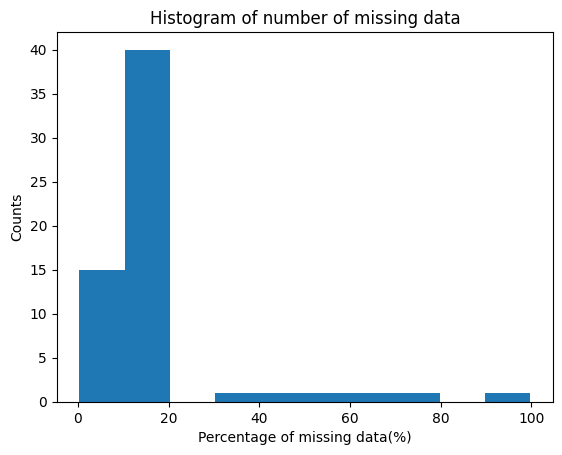

In [13]:
missing_data_per = missing_data[missing_data > 0]/(azdias.shape[0]) * 100
#sort the values
missing_data_per.sort_values(inplace=True)

plt.hist(missing_data_per)

plt.xlabel('Percentage of missing data(%)')
plt.ylabel('Counts')
plt.title('Histogram of number of missing data')
plt.show()

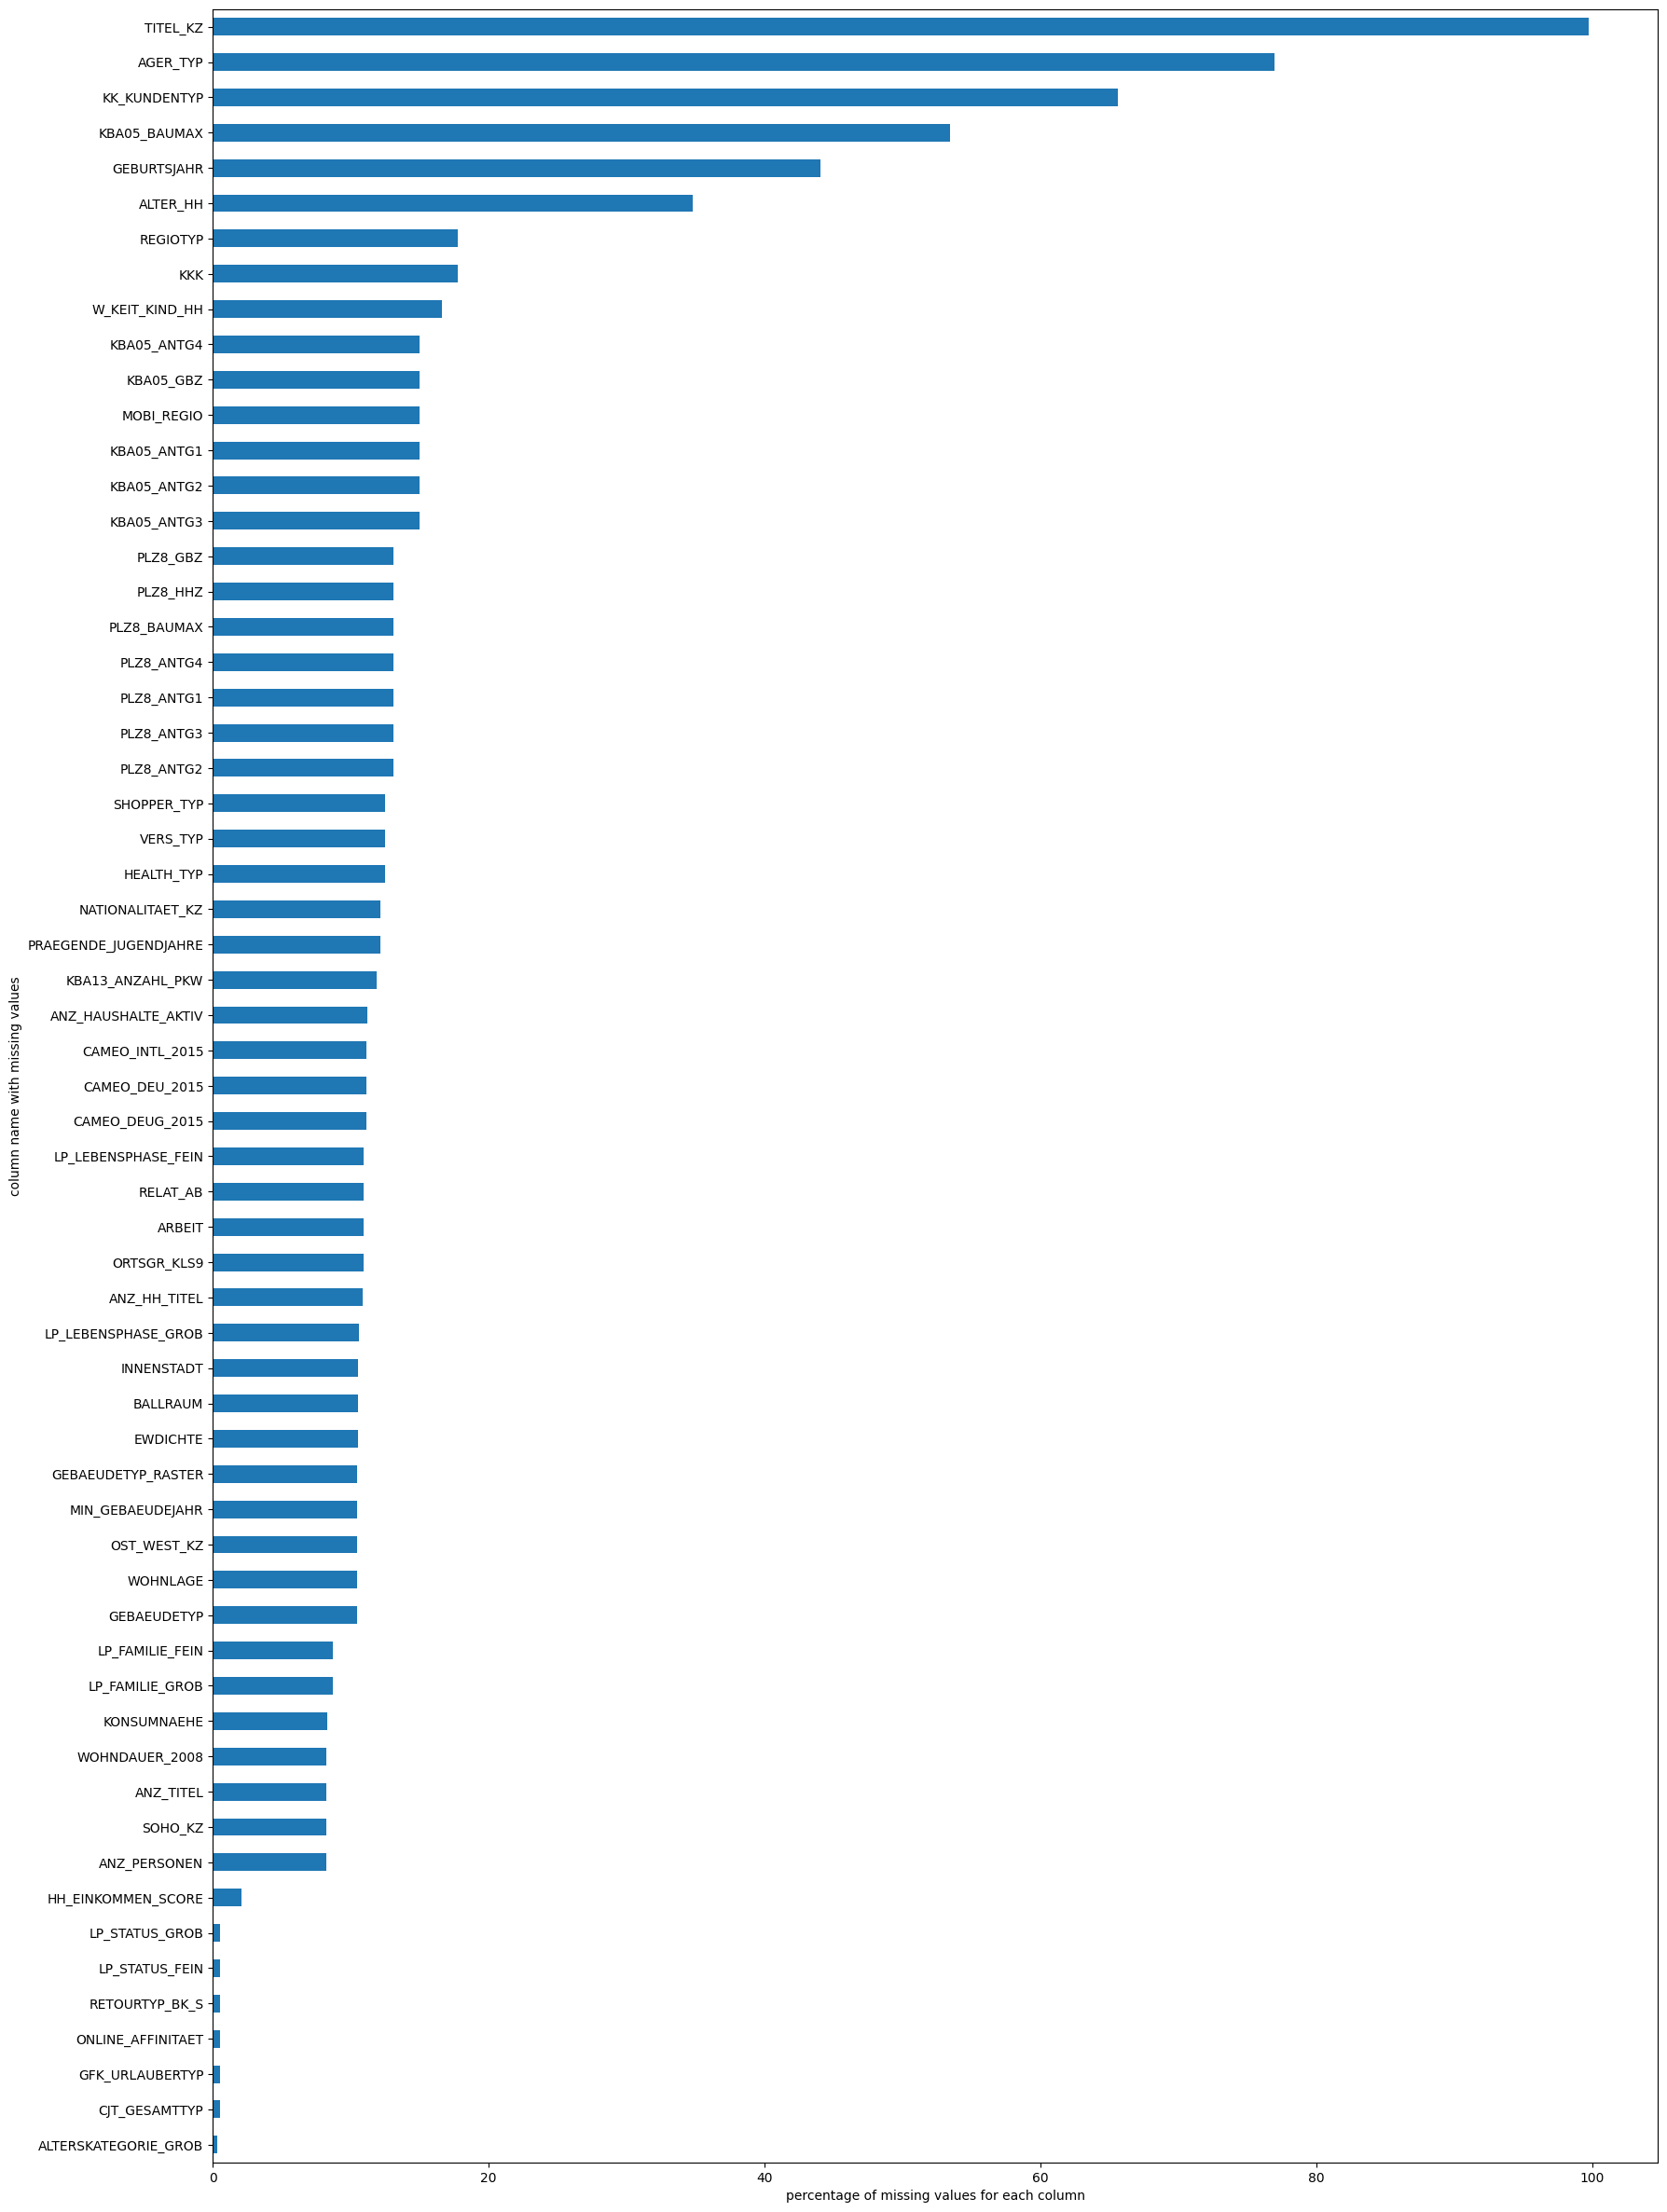

In [14]:
# Investigate patterns in the amount of missing data in each column.
missing_data_per.plot.barh(figsize=(20,30))
plt.xlabel('percentage of missing values for each column')
plt.ylabel('column name with missing values')
plt.show()

In [15]:
missing_data_per.sort_values(ascending=False)

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
MOBI_REGIO               14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG3              14.959701
KBA05_GBZ                14.959701
KBA05_ANTG4              14.959701
PLZ8_ANTG4               13.073637
PLZ8_ANTG2               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_BAUMAX              13.073637
PLZ8_HHZ                 13.073637
PLZ8_GBZ                 13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

In [16]:
# columns with more that 25% of data missing
missing_MT25 = [col for col in azdias.columns 
               if (azdias[col].isnull().sum()/azdias.shape[0])
               * 100 > 25]

print(missing_MT25)

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [17]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
for col in missing_MT25:
    azdias.drop(col, axis=1, inplace=True)


In [18]:
#check to make sure that our code was successful
missing_data_check = azdias.isnull().sum()
#get the percentage
missing_data_check = missing_data_check[missing_data_check > 0]/(azdias.shape[0]) * 100
#sort the values
missing_data_check.sort_values(inplace=True)

In [19]:
missing_data_check.sort_values(ascending = False)

REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
PLZ8_ANTG3               13.073637
PLZ8_BAUMAX              13.073637
PLZ8_HHZ                 13.073637
PLZ8_GBZ                 13.073637
PLZ8_ANTG2               13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV      11.176913
CAMEO_INTL_2015          11.147852
CAMEO_DEU_2015           11.147852
CAMEO_DEUG_2015          11.147852
LP_LEBENSPHASE_FEIN      10.954859
RELAT_AB                 10.926022
ARBEIT              

In [20]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

After analyzing the distribution of missing values across the dataset, it is evident that several columns contain a significant portion of missing data. The histogram reveals a clear distinction between columns with more than 25% missing values and those with fewer missing entries.

**Key Observations:**

1. High Missing Data Columns:

    - The following columns have over 25% missing data:
    
           'AGER_TYP'

           'GEBURTSJAHR'

           'TITEL_KZ'

           'ALTER_HH'

           'KK_KUNDENTYP'

           'KBA05_BAUMAX'

    - These columns may introduce bias or noise if retained, as their high missing rate could distort analytical results.
2. Decision to Drop Columns:

    - Since these columns contribute little reliable information due to excessive missingness, removing them is justified.

    - Their exclusion is unlikely to harm the analysis, as the remaining columns provide sufficient data for meaningful insights.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

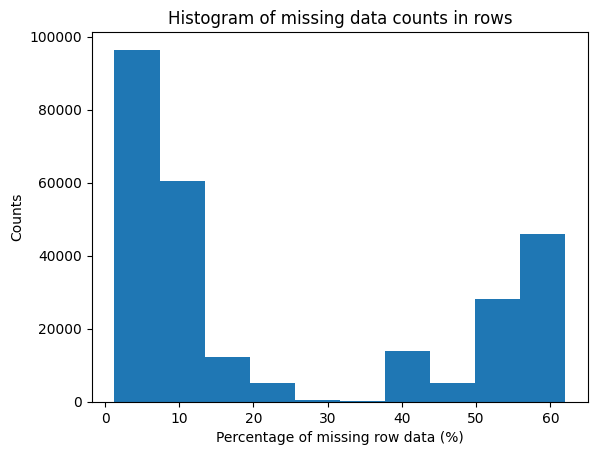

In [21]:
# How much data is missing in each row of the dataset?
missing_row_data = azdias.isnull().sum(axis=1)
missing_row_data_per = missing_row_data[missing_row_data > 0]/(len(azdias.columns)) * 100
missing_row_data_per.sort_values(inplace=True)

plt.hist(missing_row_data_per)


plt.xlabel('Percentage of missing row data (%)')
plt.ylabel('Counts')
plt.title('Histogram of missing data counts in rows')
plt.show()


In [22]:
missing_row_counts = azdias.isnull().sum(axis=1)

In [23]:
missing_row_counts.sum()

5035304

In [24]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
few_missing = azdias[azdias.isnull().sum(axis=1) <= 30].reset_index(drop=True)

many_missing = azdias[azdias.isnull().sum(axis=1) > 30].reset_index(drop=True)


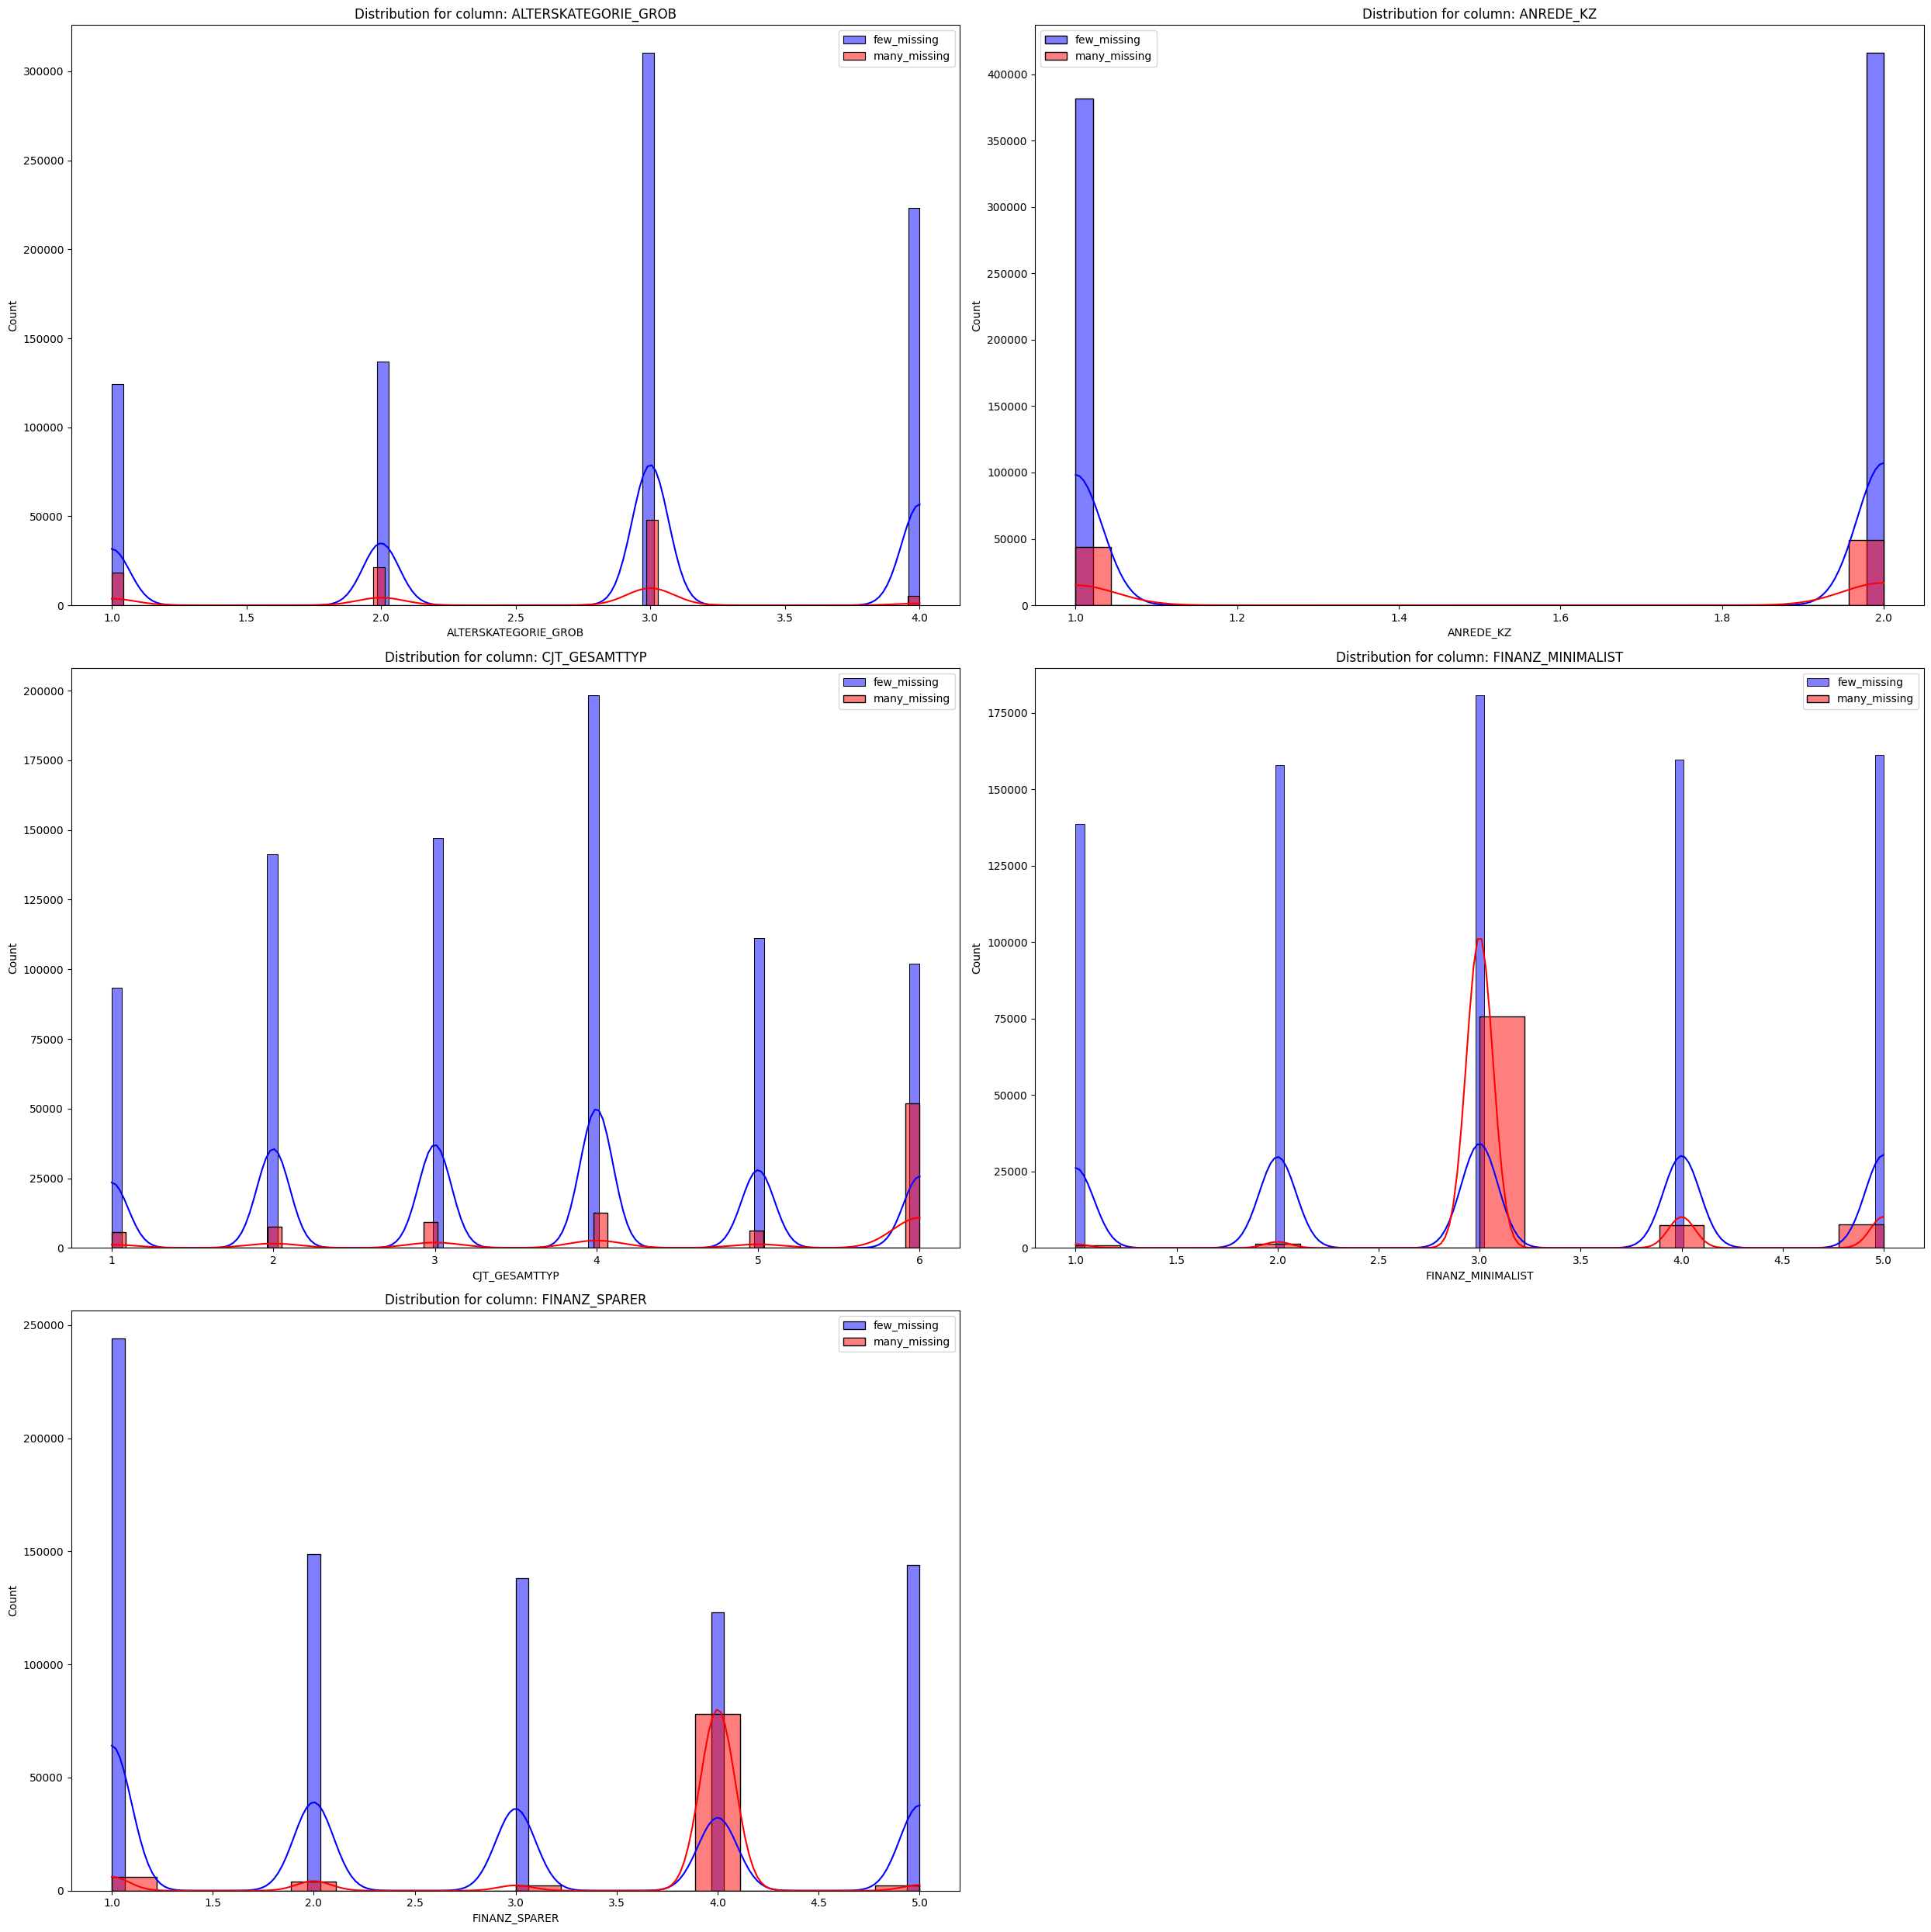

In [25]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
plt.figure(figsize=(25,25))
for i, col in enumerate(few_missing.columns[:5]):
    plt.subplot(3, 2, i+1)
    sns.histplot(few_missing[col][few_missing[col].notnull()], 
                 kde=True, 
                 color='blue', 
                 label='few_missing',
                 alpha=0.5)
    sns.histplot(many_missing[col][many_missing[col].notnull()], 
                 kde=True, 
                 color='red', 
                 label='many_missing',
                 alpha=0.5)
    plt.title('Distribution for column: {}'.format(col))
    plt.legend();
    
plt.tight_layout()
plt.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row

As we saw above in the distributions of charts the most missing values in the second subset(greater than 30) we can use a method for filling the missing values in the first subset because it's contained on few missing values. I choose the mode value to fill the missing values.

In [26]:
few_missing = few_missing.fillna(few_missing.mode().iloc[0])

In [27]:
few_missing.isnull().sum(axis=1).sum()

0

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [28]:
# How many features are there of each data type?
feat_info=feat_info[feat_info.attribute.isin(few_missing.columns)]
feat_info.type.value_counts()

type
ordinal        49
categorical    18
mixed           6
numeric         6
Name: count, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [29]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
for col in few_missing.columns:
    if feat_info.loc[feat_info['attribute'] == col, 'type'].values[0] == 'categorical':
        print(col, len(few_missing[col].unique()), few_missing[col].dtype)


ANREDE_KZ 2 int64
CJT_GESAMTTYP 6 float64
FINANZTYP 6 int64
GFK_URLAUBERTYP 12 float64
GREEN_AVANTGARDE 2 int64
LP_FAMILIE_FEIN 11 float64
LP_FAMILIE_GROB 5 float64
LP_STATUS_FEIN 10 float64
LP_STATUS_GROB 5 float64
NATIONALITAET_KZ 3 float64
SHOPPER_TYP 4 float64
SOHO_KZ 2 float64
VERS_TYP 2 float64
ZABEOTYP 6 int64
GEBAEUDETYP 7 float64
OST_WEST_KZ 2 object
CAMEO_DEUG_2015 9 object
CAMEO_DEU_2015 44 object


In [30]:
binary_cat_num = []
binary_cat_nonnum = []
multi_cat = []
for col in few_missing.columns:
    if feat_info.loc[feat_info['attribute'] == col, 'type'].values[0] == 'categorical':
        if len(few_missing[col].unique()) != 2:
            multi_cat.append(col)
        else:
            date_type = few_missing[col].dtype
            if np.issubdtype(date_type, np.number):
                binary_cat_num.append(col)
            else:
                binary_cat_nonnum.append(col)
            

In [31]:
print('Numeric binary features:\n', binary_cat_num)
print('\nNon-numeric binary features:\n', binary_cat_nonnum)
print('\nMulti-level features:\n', multi_cat)

Numeric binary features:
 ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']

Non-numeric binary features:
 ['OST_WEST_KZ']

Multi-level features:
 ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [32]:
binary_categories = binary_cat_num + binary_cat_nonnum

In [33]:
# Re-encode categorical variable(s) to be kept in the analysis.
for col in binary_categories:
    print(few_missing[col].value_counts())


ANREDE_KZ
2    416181
1    381886
Name: count, dtype: int64
GREEN_AVANTGARDE
0    622842
1    175225
Name: count, dtype: int64
SOHO_KZ
0.0    791350
1.0      6717
Name: count, dtype: int64
VERS_TYP
2.0    430964
1.0    367103
Name: count, dtype: int64
OST_WEST_KZ
W    629525
O    168542
Name: count, dtype: int64


In [34]:
# Create a mapping dictionary for all columns at once
replacement_maps = {
    "ANREDE_KZ": {2: 0, 1: 1},
    "SOHO_KZ": {0.0: 0, 1.0: 1},
    "OST_WEST_KZ": {'W': 0, 'O': 1}
}

# Apply all replacements in one operation
few_missing = few_missing.replace(replacement_maps)

# Explicit type conversion for OST_WEST_KZ
few_missing["OST_WEST_KZ"] = few_missing["OST_WEST_KZ"].astype(int)

C:\Users\MOSAB PC\AppData\Local\Temp\ipykernel_21688\818254375.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  few_missing = few_missing.replace(replacement_maps)


In [35]:
# Drop features that has more than 10 distinct values
drop_features = []
for col in few_missing.columns:
    if feat_info.loc[feat_info['attribute'] == col, 'type'].values[0] == 'categorical':
        if len(few_missing[col].unique()) >= 10:
            drop_features.append(col)
            
few_missing.drop(drop_features, axis=1, inplace=True)

for feature in drop_features:
    multi_cat.remove(feature)        


In [36]:
few_missing = pd.get_dummies(data = few_missing, columns = multi_cat, dtype=int)

#### Discussion 1.2.1: Re-Encode Categorical Features

I've dropped any column that more than 10 categories, since re-encoding this will produce large data. Which happened in our dataset that one of the columns has 44 categories.

I used the get_dummies function in pandas to encode multi_cat variables that left, and for the binary variables (numerical and non-numerical variables) I re-encoded it direct.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [37]:
# Find the column names for mixed type columns
mixed_type = []
for col in few_missing.columns:
    col_type_array = feat_info.loc[feat_info['attribute'] == col, 'type'].values
    if col_type_array.size > 0 and col_type_array[0] == 'mixed':
        mixed_type.append(col)
        
mixed_type

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

### PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [38]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
few_missing['PRAEGENDE_JUGENDJAHRE'].head()


0    14.0
1    15.0
2     8.0
3     8.0
4     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [39]:
#Map generation 
gen_dict = {0: [1, 2], 
            1: [3, 4],
            2: [5, 6, 7],
            3: [8, 9],
            4: [10, 11, 12, 13], 
            5:[14, 15]}

def map_gen(x):
    try:
        for key, array in gen_dict.items():
            if x in array:
                return key
    except ValueError:
        return np.nan
    
# Map movement 
mainstream = [1, 3, 5, 8, 10, 12, 14]

def map_mov(x):
    try:
        if x in mainstream:
            return 0
        else:
            return 1
    except ValueError:
        return np.nan

In [40]:
# Create generation column
few_missing["DECADE"] = few_missing['PRAEGENDE_JUGENDJAHRE'].apply(map_gen)

# Create movement column
few_missing["MOVEMENT"] = few_missing['PRAEGENDE_JUGENDJAHRE'].apply(map_mov)

In [41]:
# drop the original column
few_missing.drop(['PRAEGENDE_JUGENDJAHRE'], axis = 1, inplace=True)

In [42]:
few_missing.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,DECADE,MOVEMENT
0,1.0,0,1,5,2,5,4,5,0,3.0,21.0,6.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,5,0
1,3.0,0,1,4,1,2,3,5,1,3.0,3.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,5,1
2,4.0,0,4,2,5,2,1,2,0,2.0,1.0,2.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,6.0,9.0,1.0,0.0,4.0,1997.0,0,7.0,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,3.0,4.0,1.0,6.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,0
3,3.0,1,4,3,4,1,3,2,0,3.0,32.0,10.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0,3.0,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3,0
4,1.0,0,3,1,5,2,2,5,0,3.0,8.0,2.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,0,7.0,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


### CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [43]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
few_missing['CAMEO_INTL_2015'].head()


0    51
1    24
2    12
3    43
4    54
Name: CAMEO_INTL_2015, dtype: object

In [44]:
# Map wealth 
def map_wealth(x):
    # Check of nan first, or it will convert nan to string 'nan'
    try:
        if pd.isnull(x):
            return np.nan
        else:
            return int(str(x)[0])
    except ValueError:
        return np.nan

# Map life stage
def map_lifestage(x):
    try:
        if pd.isnull(x):
            return np.nan
        else:
            return int(str(x)[1])
    except ValueError:
        return np.nan

In [45]:
# Create wealth column
few_missing['WEALTH'] = few_missing['CAMEO_INTL_2015'].apply(map_wealth)

# Create life stage column
few_missing['LIFE_STAGE'] = few_missing['CAMEO_INTL_2015'].apply(map_lifestage)

In [46]:
# drop the original column
few_missing.drop(['CAMEO_INTL_2015'], axis = 1, inplace=True)

In [47]:
few_missing.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,1.0,0,1,5,2,5,4,5,0,3.0,21.0,6.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0,4.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,5,0,5,1
1,3.0,0,1,4,1,2,3,5,1,3.0,3.0,1.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0,2.0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,5,1,2,4
2,4.0,0,4,2,5,2,1,2,0,2.0,1.0,2.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,6.0,9.0,1.0,0.0,4.0,1997.0,0,7.0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,3.0,4.0,1.0,6.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,0,1,2
3,3.0,1,4,3,4,1,3,2,0,3.0,32.0,10.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0,3.0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3,0,4,3
4,1.0,0,3,1,5,2,2,5,0,3.0,8.0,2.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,0,7.0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,5,4


#### Discussion 1.2.2: Engineer Mixed-Type Features

I kept on two mixed features PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015.
In PRAEGENDE_JUGENDJAHRE I just ignored the third dimension which is a nation (east vs. west).

#### The steps which I used to engineer the mixed-type features as following:
1. Created Mapping Dictionaries.

2. Built Mapping Functions.

3. Applied Transformations.

4. Cleaned Original Data.
    
with CAMEO_INTL_2015, I systematically decomposed the two-digit CAMEO_INTL_2015 codes by separating the tens and ones places into distinct ordinal variables. The tens digit represents household wealth levels, while the ones digit indicates life stage classification. My implementation used string conversion and positional indexing to precisely extract each digit - ``` str(x)[0]``` for wealth (tens place) and ```str(x)[1]``` for life stage (ones place). 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [48]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
mixed_variables=feat_info[feat_info.type=="mixed"]
for mixed_feature in mixed_variables["attribute"]:
    if mixed_feature in few_missing.columns:
        print(mixed_feature)
        few_missing.drop(mixed_feature,axis=1,inplace=True)

LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB
WOHNLAGE
PLZ8_BAUMAX


In [49]:
few_missing.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,1.0,0,1,5,2,5,4,5,0,3.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,5,0,5,1
1,3.0,0,1,4,1,2,3,5,1,3.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,5,1,2,4
2,4.0,0,4,2,5,2,1,2,0,2.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,6.0,9.0,1.0,0.0,4.0,1997.0,0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,3.0,4.0,1.0,6.0,596.0,2.0,2.0,2.0,0.0,3.0,4.0,2.0,3.0,3.0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,0,1,2
3,3.0,1,4,3,4,1,3,2,0,3.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,3.0,3.0,4.0,6.0,5.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3,0,4,3
4,1.0,0,3,1,5,2,2,5,0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,5,4


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [50]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')
    
    # Identify missing or unknown data values and convert them to NaNs.
    for attribute, miss_index in zip(feat_info['attribute'], feat_info['missing_or_unknown']):
        missing_values = miss_index.strip('[]').split(',')
        missing_values = [int(value) if (value != 'X' and value != 'XX' and value != '') else value for value in missing_values]
        if missing_values != ['']:
            df[attribute] = df[attribute].replace(missing_values, np.nan)
    
    # remove selected columns and rows, ...
    # columns with more that 25% of data missing
    missing_MT25 = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    for col in missing_MT25:
        df.drop(col, axis=1, inplace=True) 
    # rows
    few_missing = df[df.isnull().sum(axis=1) <= 30].reset_index(drop=True)
    many_missing = df[df.isnull().sum(axis=1) > 30].reset_index(drop=True)

    few_missing = few_missing.fillna(few_missing.mode().iloc[0])
    # select, re-encode, and engineer column values.
    feat_info=feat_info[feat_info.attribute.isin(few_missing.columns)]
    
    binary_categories = []
    multi_cat = []
    for col in few_missing.columns:
        if feat_info.loc[feat_info['attribute'] == col, 'type'].values[0] == 'categorical':
            if len(few_missing[col].unique()) != 2:
                multi_cat.append(col)
            else:
                binary_categories.append(col)
    
    
    replacement_maps = {
    "ANREDE_KZ": {2: 0, 1: 1},
    "SOHO_KZ": {0.0: 0, 1.0: 1},
    "OST_WEST_KZ": {'W': 0, 'O': 1}
    }

    few_missing = few_missing.replace(replacement_maps)
    few_missing["OST_WEST_KZ"] = few_missing["OST_WEST_KZ"].astype(int)
    
    # Drop features that has more than 10 distinct values
    drop_features = []
    for col in few_missing.columns:
        if feat_info.loc[feat_info['attribute'] == col, 'type'].values[0] == 'categorical':
            if len(few_missing[col].unique()) >= 10:
                drop_features.append(col)

    few_missing.drop(drop_features, axis=1, inplace=True)

    for feature in drop_features:
        multi_cat.remove(feature)   
        
    few_missing = pd.get_dummies(data = few_missing, columns = multi_cat, dtype=int)

    # Complete the mapping process of mixed features
    few_missing["DECADE"] = few_missing['PRAEGENDE_JUGENDJAHRE'].apply(map_gen)
    few_missing["MOVEMENT"] = few_missing['PRAEGENDE_JUGENDJAHRE'].apply(map_mov)
    few_missing.drop(['PRAEGENDE_JUGENDJAHRE'], axis = 1, inplace=True)

    few_missing['WEALTH'] = few_missing['CAMEO_INTL_2015'].apply(map_wealth)
    few_missing['LIFE_STAGE'] = few_missing['CAMEO_INTL_2015'].apply(map_lifestage)
    few_missing.drop(['CAMEO_INTL_2015'], axis = 1, inplace=True)

    
    #drop mixed
    mixed_variables=feat_info[feat_info.type=="mixed"]
    for mixed_feature in mixed_variables["attribute"]:
        if mixed_feature in few_missing.columns:
            few_missing.drop(mixed_feature,axis=1,inplace=True)    
            
    # interpolate again to clean the data set
    for col in few_missing.columns:
        few_missing[col] = few_missing[col].interpolate(limit_direction='both')
        
    # Return the cleaned dataframe.
    return few_missing
    

In [51]:
azdias_test = pd.read_csv("Udacity_AZDIAS_Subset.csv",sep=';')
test_df=clean_data(azdias_test)

C:\Users\MOSAB PC\AppData\Local\Temp\ipykernel_21688\2174813164.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  few_missing = few_missing.replace(replacement_maps)


In [52]:
def compare_cleaning(manual_clean, auto_clean):
    print("=== Starting Tests ===")
    
    assert manual_clean.shape[0] == auto_clean.shape[0], \
        f"Row count mismatch: {manual_clean.shape[0]} (manual) vs {auto_clean.shape[0]} (auto)"
    
    assert manual_clean.shape[1] == auto_clean.shape[1], \
        f"Column count mismatch: {manual_clean.shape[1]} (manual) vs {auto_clean.shape[1]} (auto)"
    
    
    assert auto_clean.isnull().sum().sum() == 0, \
        "Auto-cleaned data contains missing values"
    
    assert set(manual_clean.columns) == set(auto_clean.columns), \
        "Column names don't match between manual and auto cleaning"
    
    print("All tests passed! Results are identical.")

compare_cleaning(few_missing, test_df)


print("\nDetailed column comparison:")
for col in few_missing.columns:
    if col in test_df.columns:
        try:
            pd.testing.assert_series_equal(few_missing[col], test_df[col], check_names=False)
            print(f"✓ {col} matches")
        except AssertionError:
            print(f"✗ {col} has differences")

=== Starting Tests ===
All tests passed! Results are identical.

Detailed column comparison:
✓ ALTERSKATEGORIE_GROB matches
✓ ANREDE_KZ matches
✓ FINANZ_MINIMALIST matches
✓ FINANZ_SPARER matches
✓ FINANZ_VORSORGER matches
✓ FINANZ_ANLEGER matches
✓ FINANZ_UNAUFFAELLIGER matches
✓ FINANZ_HAUSBAUER matches
✓ GREEN_AVANTGARDE matches
✓ HEALTH_TYP matches
✓ RETOURTYP_BK_S matches
✓ SEMIO_SOZ matches
✓ SEMIO_FAM matches
✓ SEMIO_REL matches
✓ SEMIO_MAT matches
✓ SEMIO_VERT matches
✓ SEMIO_LUST matches
✓ SEMIO_ERL matches
✓ SEMIO_KULT matches
✓ SEMIO_RAT matches
✓ SEMIO_KRIT matches
✓ SEMIO_DOM matches
✓ SEMIO_KAEM matches
✓ SEMIO_PFLICHT matches
✓ SEMIO_TRADV matches
✓ SOHO_KZ matches
✓ VERS_TYP matches
✓ ANZ_PERSONEN matches
✓ ANZ_TITEL matches
✓ HH_EINKOMMEN_SCORE matches
✓ W_KEIT_KIND_HH matches
✓ WOHNDAUER_2008 matches
✓ ANZ_HAUSHALTE_AKTIV matches
✓ ANZ_HH_TITEL matches
✓ KONSUMNAEHE matches
✓ MIN_GEBAEUDEJAHR matches
✓ OST_WEST_KZ matches
✓ KBA05_ANTG1 matches
✓ KBA05_ANTG2 matches
✓ 

In [53]:
test_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,1.0,0,1,5,2,5,4,5,0,3.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,5,0,5,1
1,3.0,0,1,4,1,2,3,5,1,3.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,5,1,2,4
2,4.0,0,4,2,5,2,1,2,0,2.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,6.0,9.0,1.0,0.0,4.0,1997.0,0,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,3.0,4.0,1.0,6.0,596.0,2.0,2.0,2.0,0.0,3.0,4.0,2.0,3.0,3.0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,0,1,2
3,3.0,1,4,3,4,1,3,2,0,3.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,3.0,3.0,4.0,6.0,5.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3,0,4,3
4,1.0,0,3,1,5,2,2,5,0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,5,4


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [54]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

missing_count = few_missing.isnull().sum().sum()
print(f"Total missing values before handling: {missing_count}")

# Handle missing values (if any exist)
if missing_count > 0:
    # Impute with mean (for numerical features)
    few_missing = few_missing.fillna(few_missing.mean())
    
    print("Missing values have been imputed")

# Verify no missing values remain
assert few_missing.isnull().sum().sum() == 0, "There are still missing values!"


Total missing values before handling: 0


In [55]:
# Apply feature scaling to the general population demographics data.
# convert a pandas data frame to a numpy matrix for scikit-learn
scaler = StandardScaler()
few_missing[few_missing.columns] = scaler.fit_transform(few_missing[few_missing.columns].to_numpy())

In [56]:
#check the stats, mean, etc
few_missing.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
count,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05,7.980670e+05
mean,-1.320003e-16,-8.716328e-17,5.657155e-17,-1.007675e-16,1.164640e-16,1.377340e-17,4.154278e-17,-1.895334e-16,-1.104899e-17,2.394809e-16,1.348849e-18,8.304550e-17,6.091636e-17,1.940919e-18,6.134371e-18,2.115601e-16,2.120498e-16,1.769085e-16,-1.305891e-16,-1.729198e-16,5.967880e-17,-2.576792e-16,2.900694e-17,-1.856694e-16,-1.355082e-16,-1.736143e-18,-7.072779e-17,1.207287e-16,3.648571e-17,2.181842e-16,8.087755e-17,1.798466e-17,-3.774998e-17,2.740435e-17,7.888321e-17,-1.373679e-14,1.602593e-18,-1.070176e-16,-3.984225e-19,-7.874966e-17,-5.667839e-17,5.794266e-17,2.276573e-16,1.134280e-16,5.666503e-17,-1.568672e-16,-1.006785e-16,1.470647e-16,6.094752e-17,8.563191e-17,1.169893e-17,-1.589238e-16,-2.472980e-16,1.575884e-18,4.257557e-17,-9.509611e-17,-1.752703e-16,1.365766e-17,6.716647e-17,-1.462812e-17,-2.377180e-18,1.178129e-17,-3.716236e-17,-2.917610e-17,-4.905717e-

In [57]:
few_missing.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-1.766647,-0.957912,-1.494594,1.537920,-1.040686,1.465965,0.958633,1.339319,-0.530407,1.010156,-1.685452,0.443205,-0.059355,0.002834,-0.463909,-1.684507,-1.109913,-1.435372,-0.578164,1.274185,-0.312196,1.339262,-0.157565,1.518699,1.288987,10.85417,0.922940,0.234458,-0.060408,1.026720,-0.730192,0.567332,0.173104,-0.125133,-1.304533,-0.383167,-0.517425,-1.008836,-0.965690,-0.594874,2.730674,-1.659274,0.845251,-0.547161,1.701105,-0.799742,-0.791629,-1.279712,0.166966,-0.882469,0.942501,-0.256528,0.211982,0.402977,0.442535,1.455855,0.574309,-0.171399,-0.127042,0.684885,-0.363871,-0.463775,-0.475602,-0.584157,2.486447,-0.383035,1.745728,-0.388748,-0.243882,-0.274508,-0.392071,-0.753587,-1.091911,-0.375355,5.300541,-0.258204,-0.555456,1.213647,-0.521200,-0.223906,-0.491324,-0.403147,0.370255,-0.294396,-0.206254,-0.435290,-0.743559,-0.589732,1.847296,-0.427793,-0.207702,-0.739709,-0.592816,2.976102,-0.31217,-1.167868,-0.078873,-0.537077,-0.033601,-0.001119,-0.028063,2.057697,-0.218017,-0.341222,-0.349286,-0.386903,-0.272884,-0.391094,-0.328968,2.162049,-0.395984,1.098064,-0.530407,1.175655,-1.248888
1,0.200522,-0.957912,-1.494594,0.864560,-1.766972,-0.570999,0.244109,1.339319,1.885345,1.010156,-0.310902,-0.072013,-1.626994,-0.520587,-0.463909,-0.142554,-0.158741,0.754262,-0.578164,0.064233,1.391992,1.339262,1.448745,-0.638942,-0.410210,-0.09213,-1.083494,-0.630198,-0.060408,-0.267573,-0.730192,0.567332,0.109101,-0.125133,1.274844,-0.383167,-0.517425,-0.297919,1.444756,0.408133,-0.464084,-0.116192,-0.986687,0.034482,-0.271086,0.283466,-0.791629,0.092849,-0.476480,-1.435271,0.227651,0.786631,0.211982,-0.623111,-0.934791,0.419746,0.574309,-0.171399,-0.127042,-0.789025,-0.363871,-0.463775,2.102597,-0.584157,-0.402180,-0.383035,1.745728,-0.388748,-0.243882,-0.274508,-0.392071,-0.753587,0.915826,-0.375355,-0.188660,-0.258204,-0.555456,-0.823963,1.918648,-0.223906,-0.491324,-0.403147,0.370255,-0.294396,-0.206254,-0.435290,-0.743559,1.695687,-0.541332,-0.427793,-0.207702,-0.739709,-0.592816,2.976102,-0.31217,0.856262,-0.078873,-0.537077,-0.033601,-0.001119,-0.028063,-0.485980,-0.218017,-0.341222,-0.349286,2.584626,-0.272884,-0.391094,-0.328968,-0.462524,-0.395984,1.098064,1.885345,-0.869682,0.767097
2,1.184107,-0.957912,0.683145,-0.482159,1.138172,-0.570999,-1.184938,-0.791197,-0.530407,-0.311824,-0.998177,0.443205,-1.626994,-1.044008,-1.509281,-0.

### Discussion 2.1: Apply Feature Scaling

All missing values were checked and confirmed to be zero. Then, feature scaling was applied using StandardScaler to normalize the data, ensuring equal weight across all features for accurate analysis.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [58]:
# Apply PCA to the data.
pca = PCA()
few_missing_pca = pca.fit_transform(few_missing)


In [59]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

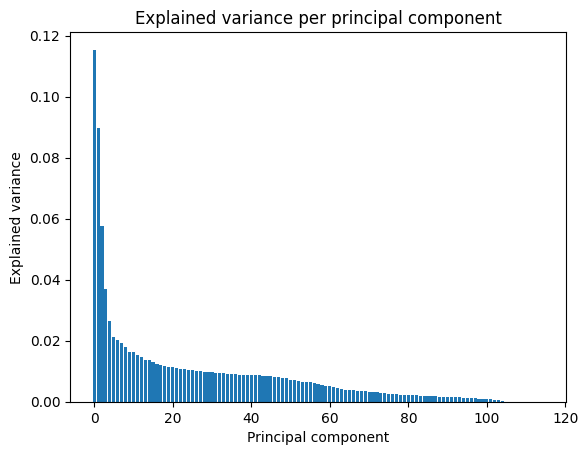

In [60]:
num_components=np.arange(len(pca.explained_variance_ratio_))
values=pca.explained_variance_ratio_
plt.bar(num_components,values)
plt.xlabel("Principal component")
plt.ylabel("Explained variance")
plt.title("Explained variance per principal component")
plt.show()

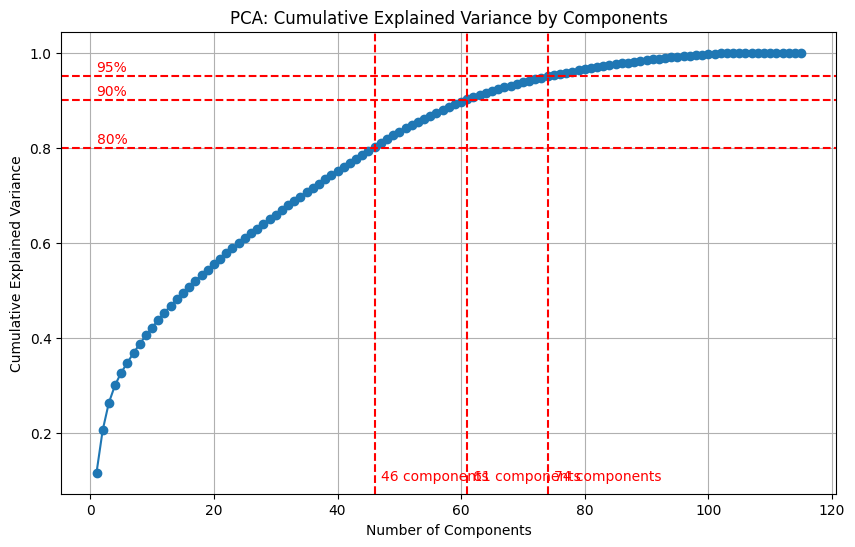

In [61]:
# Investigate the variance accounted for by each principal component.
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance by Components')
plt.grid(True)
for threshold in [0.8, 0.9, 0.95]:
    closest = np.argmax(cumulative_variance >= threshold) + 1
    plt.axhline(y=threshold, color='r', linestyle='--')
    plt.axvline(x=closest, color='r', linestyle='--')
    plt.text(1, threshold+0.01, f'{threshold*100:.0f}%', color='r')
    plt.text(closest+1, 0.1, f'{closest} components', color='r')
    
plt.show()



In [62]:
optimal_components = np.argmax(cumulative_variance >= 0.9) + 1

In [63]:
print(f"\nTotal features: {few_missing.shape[1]}")
print(f"Recommended components: {optimal_components}")
print(f"Variance explained with {optimal_components} components: {cumulative_variance[optimal_components-1]:.3f}")


Total features: 115
Recommended components: 61
Variance explained with 61 components: 0.902


In [64]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=optimal_components)
few_missing_pca = pca.fit_transform(few_missing)


### Discussion 2.2: Perform Dimensionality Reduction

Looking at the cumulative variance plot, the analysis showed that 61 principal components explain 90.2% of the total variance in the data. I chose to retain these 61 components because:

1. Optimal Trade-off: Beyond 61 components, each additional feature contributed minimally to explained variance (curve flattened significantly).

2. Efficiency: Reducing dimensions from 115 to 61 (47% reduction) improves computational performance for clustering while preserving critical patterns.

3. Threshold Justification: The 90% variance threshold captures the majority of meaningful variability without overcomplicating the model.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [65]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def analyze_principal_component(pca, feature_names, component_idx, n_features=5):
    """
    Analyzes and interprets a principal component by displaying:
    - Top positive/negative feature weights
    - Explained variance
    - Suggested interpretation
    
    Args:
        pca: Fitted PCA object
        feature_names: List of original feature names
        component_idx: Zero-based index of the principal component
        n_features: Number of top features to display
    """
    # Create weights DataFrame
    weights = pd.DataFrame({
        'feature': feature_names,
        'weight': pca.components_[component_idx]
    }).sort_values('weight', key=abs, ascending=False)
    
    # Display component info
    pc_num = component_idx + 1
    explained_var = pca.explained_variance_ratio_[component_idx]
    print(f"\n=== Principal Component {pc_num} (Explained Variance: {explained_var:.3f}) ===")
    
    # Display top features
    print(f"\nTop {n_features} influential features:")
    display(weights.head(n_features))
    
    # Interpretation helper
    pos_features = weights.head(n_features)
    neg_features = weights.tail(n_features)
    
    print("\nSuggested interpretation:")
    print(f"PC{pc_num} contrasts:")
    print(f"+ {', '.join(pos_features['feature'].tolist())}")
    print(f"- {', '.join(neg_features['feature'].tolist())}")
    
    return weights

# Example usage for first 3 components
for i in range(3):
    component_weights = analyze_principal_component(
        pca = pca,
        feature_names = few_missing.columns,  # Your scaled feature names
        component_idx = i
    )



=== Principal Component 1 (Explained Variance: 0.115) ===

Top 5 influential features:


,feature,weight
2,FINANZ_MINIMALIST,0.211568
77,LP_STATUS_GROB_1.0,-0.201173
47,MOBI_REGIO,0.195828
51,PLZ8_ANTG1,0.191130
53,PLZ8_ANTG3,-0.190020



Suggested interpretation:
PC1 contrasts:
+ FINANZ_MINIMALIST, LP_STATUS_GROB_1.0, MOBI_REGIO, PLZ8_ANTG1, PLZ8_ANTG3
- GEBAEUDETYP_6.0, FINANZTYP_5, SOHO_KZ, CAMEO_DEUG_2015_6, GEBAEUDETYP_5.0

=== Principal Component 2 (Explained Variance: 0.090) ===

Top 5 influential features:


,feature,weight
0,ALTERSKATEGORIE_GROB,0.227920
111,DECADE,-0.222308
13,SEMIO_REL,-0.216483
3,FINANZ_SPARER,-0.212797
6,FINANZ_UNAUFFAELLIGER,-0.212301



Suggested interpretation:
PC2 contrasts:
+ ALTERSKATEGORIE_GROB, DECADE, SEMIO_REL, FINANZ_SPARER, FINANZ_UNAUFFAELLIGER
- SOHO_KZ, KBA05_ANTG2, GEBAEUDETYP_4.0, GEBAEUDETYP_6.0, GEBAEUDETYP_5.0

=== Principal Component 3 (Explained Variance: 0.058) ===

Top 5 influential features:


,feature,weight
1,ANREDE_KZ,0.351310
15,SEMIO_VERT,0.325001
22,SEMIO_KAEM,-0.322632
21,SEMIO_DOM,-0.295879
20,SEMIO_KRIT,-0.269517



Suggested interpretation:
PC3 contrasts:
+ ANREDE_KZ, SEMIO_VERT, SEMIO_KAEM, SEMIO_DOM, SEMIO_KRIT
- CAMEO_DEUG_2015_7, CAMEO_DEUG_2015_5, FINANZTYP_4, GEBAEUDETYP_5.0, SOHO_KZ


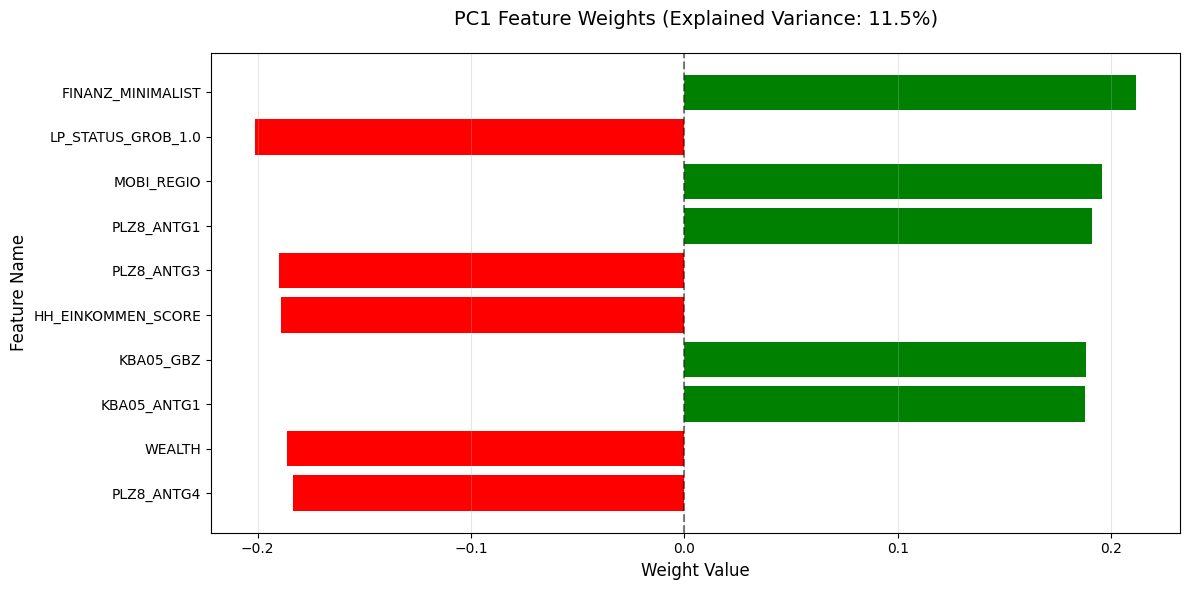

Interpretation Guide:
PC1 represents a contrast between:
+ FINANZ_MINIMALIST, MOBI_REGIO, PLZ8_ANTG1, KBA05_GBZ, KBA05_ANTG1
- LP_STATUS_GROB_1.0, PLZ8_ANTG3, HH_EINKOMMEN_SCORE, WEALTH, PLZ8_ANTG4

Color Key: Green = Positive, Red = Negative


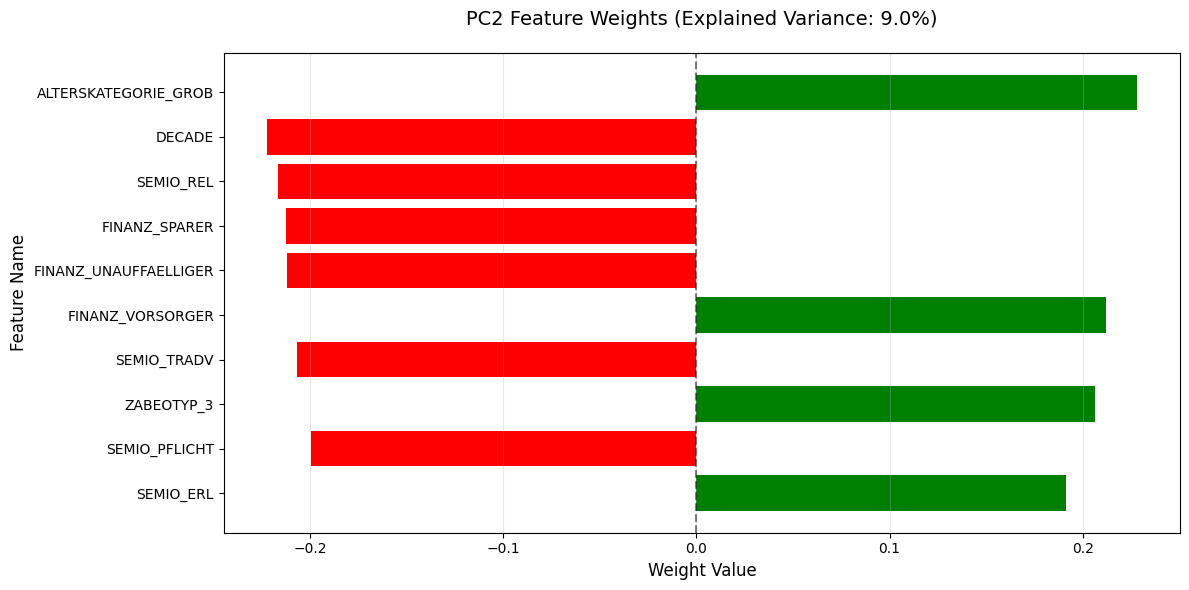

Interpretation Guide:
PC2 represents a contrast between:
+ ALTERSKATEGORIE_GROB, FINANZ_VORSORGER, ZABEOTYP_3, SEMIO_ERL
- DECADE, SEMIO_REL, FINANZ_SPARER, FINANZ_UNAUFFAELLIGER, SEMIO_TRADV, SEMIO_PFLICHT

Color Key: Green = Positive, Red = Negative


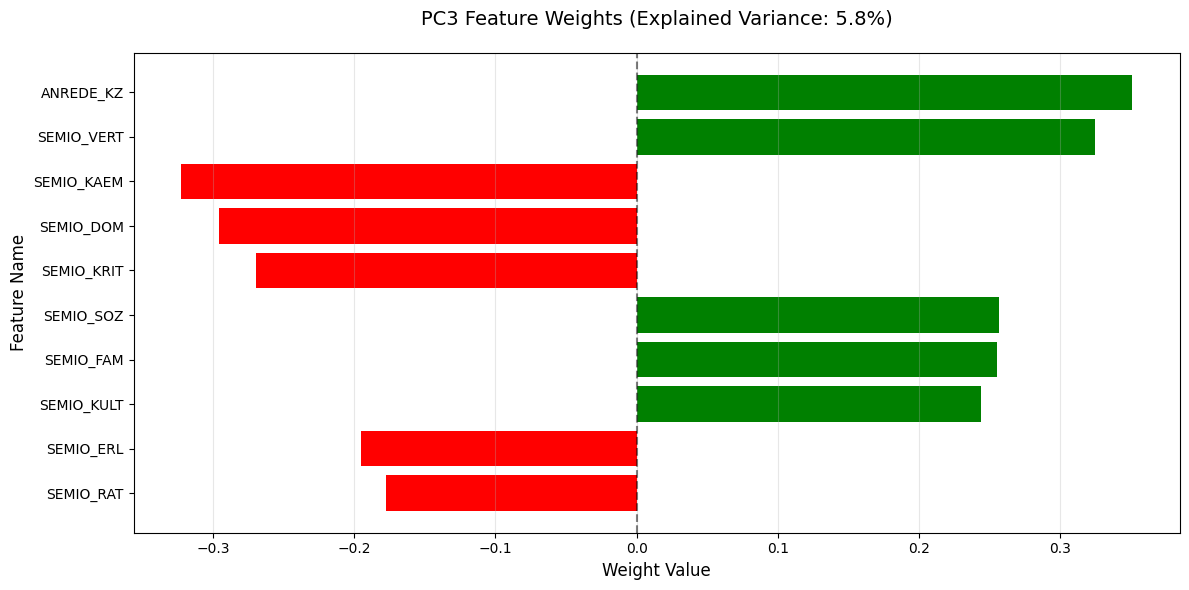

Interpretation Guide:
PC3 represents a contrast between:
+ ANREDE_KZ, SEMIO_VERT, SEMIO_SOZ, SEMIO_FAM, SEMIO_KULT
- SEMIO_KAEM, SEMIO_DOM, SEMIO_KRIT, SEMIO_ERL, SEMIO_RAT

Color Key: Green = Positive, Red = Negative


In [66]:
#draw plot for visualizing those weights
def plot_pca_weights(pca, feature_names, component_idx, n_features=10):
    """
    Visualizes feature weights for a principal component with interpretation.
    
    Args:
        pca: Fitted PCA object
        feature_names: List of feature names
        component_idx: Index of principal component (0-based)
        n_features: Number of top features to display
    """
    pc_num = component_idx + 1
    weights = pca.components_[component_idx]
    explained_var = pca.explained_variance_ratio_[component_idx]
    
    # Sort features by absolute weight
    sorted_idx = np.argsort(np.abs(weights))[::-1]
    sorted_features = [feature_names[i] for i in sorted_idx[:n_features]]
    sorted_weights = weights[sorted_idx[:n_features]]
    
    # Create plot
    plt.figure(figsize=(12, 6))
    colors = ['green' if w > 0 else 'red' for w in sorted_weights]
    bars = plt.barh(sorted_features, sorted_weights, color=colors)
    
    # Formatting
    plt.title(f'PC{pc_num} Feature Weights (Explained Variance: {explained_var:.1%})',
              fontsize=14, pad=20)
    plt.xlabel('Weight Value', fontsize=12)
    plt.ylabel('Feature Name', fontsize=12)
    plt.axvline(0, color='black', linestyle='--', alpha=0.5)
    
    # Add interpretation text
    pos_features = [f for f,w in zip(sorted_features, sorted_weights) if w > 0]
    neg_features = [f for f,w in zip(sorted_features, sorted_weights) if w < 0]
    
    interpretation = (f"PC{pc_num} represents a contrast between:\n"
                     f"+ {', '.join(pos_features)}\n"
                     f"- {', '.join(neg_features)}")
    
    plt.gca().invert_yaxis()  # Highest weight at top
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("Interpretation Guide:")
    print(interpretation)
    print("\nColor Key: Green = Positive, Red = Negative")

# Visualize first 3 components
for i in range(3):
    plot_pca_weights(pca, few_missing.columns, i)

### Discussion 2.3: Interpret Principal Components

Based on the analysis of the first three principal components, we can make the following interpretations:

#### Principal Component 1 (11.5% Variance Explained)
**Key Contrasts:**

* Positive Association:

    - FINANZ_MINIMALIST: Financial minimalism/low financial interest

    - MOBI_REGIO: Movement patterns (higher = less movement)

    - PLZ8_ANTG1: Number of 1-2 family houses in region

* Negative Association:

    - LP_STATUS_GROB_1.0: Low-income earners

    - PLZ8_ANTG3: Number of 6-10 family houses

**Interpretation:**
This component appears to represent an urban vs. residential lifestyle dimension. The positive weights suggest characteristics of settled, financially conservative residents in single-family homes, while negative weights indicate higher-density housing and lower-income populations.

#### Principal Component 2 (9.0% Variance Explained)
**Key Contrasts:**

* Positive Association:

    - ALTERSKATEGORIE_GROB: Estimated age

* Negative Association:

    - DECADE: Generation/youth decade

    - SEMIO_REL: Religious personality

    - FINANZ_SPARER: Money-saver attitude

**Interpretation:**
This component clearly represents a age-generation axis, contrasting older individuals with younger generations and their associated traits (less religious, less savings-oriented). This likely captures fundamental demographic differences in the population.

#### Principal Component 3 (5.8% Variance Explained)
**Key Contrasts:**

* Positive Association:

    - ANREDE_KZ: Gender (male=1, female=2)

    - SEMIO_VERT: Dreamful personality

* Negative Association:

    - SEMIO_KAEM: Combative attitude

    - SEMIO_DOM: Dominant personality

**Interpretation:**
This component reveals a gender-personality dimension, contrasting typically feminine traits (dreamful, positive weights) with traditionally masculine traits (combative, dominant, negative weights). The strong gender signal (ANREDE_KZ) confirms this interpretation.

##### Meaningful Patterns Observed:
* Urban-Suburban Spectrum (PC1): Shows how housing density correlates with financial attitudes and mobility

* Age-Generation Divide (PC2): Reveals how fundamental demographic factors cluster with personality traits

* Gender-Personality Axis (PC3): Demonstrates clear gender-based personality differences in the population

##### Practical Implications:
These interpretations suggest that:

* Marketing campaigns should consider urban/rural differences (PC1)

* Product development should account for age-generation values (PC2)

* Customer service approaches might vary by gender personality traits (PC3)   

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [67]:

def calculate_sse(pca_data, max_clusters=15):
    """
    Calculate SSE values for different numbers of clusters
    
    Args:
        pca_data: PCA-transformed data
        max_clusters: Maximum number of clusters to test
        
    Returns:
        tuple: (sse_values, k_range)
    """
    # Initialize variables
    sse_values = []
    k_range = list(range(1,30,2))
    
    # Over a number of different cluster counts...
    for k in k_range:
        # run k-means clustering on the data and...
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(pca_data)

        # compute the average within-cluster distances.
        sse = -kmeans.score(pca_data)   # Convert negative score to SSE
        sse_values.append(sse)
        print(f"k={k:2d} | SSE: {sse:.2e}")
    
    return sse_values, k_range

In [68]:
def find_elbow_point(sse_values):
    """
    Automatically determine the optimal number of clusters using elbow method
    
    Args:
        sse_values: List of SSE values for different cluster counts
        
    Returns:
        int: Optimal number of clusters
    """
    kl = KneeLocator(range(1, len(sse_values)+1), 
                    sse_values, 
                    curve='convex', 
                    direction='increasing')
    return kl.elbow

In [69]:
# Investigate the change in within-cluster distance across number of clusters.

def plot_elbow_curve(k_range, sse_values, optimal_k):
    """
    Visualize the elbow curve with marked optimal point
    
    Args:
        k_range: Range of cluster counts tested
        sse_values: Corresponding SSE values
        optimal_k: Optimal number of clusters
    """
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, sse_values, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Sum of Squared Errors (SSE)')
    plt.title('Elbow Method for Optimal k')
    plt.xticks(k_range)
    plt.grid(True)

    plt.axvline(x=optimal_k, color='r', linestyle='--')
    plt.text(optimal_k+0.5, 0.9*sse_values[0], 
            f'Optimal k: {optimal_k}', color='r')
    plt.show()

In [70]:
def perform_full_analysis(pca_data, max_clusters=15):
    """
    Complete workflow for cluster analysis
    
    Args:
        pca_data: PCA-transformed data
        max_clusters: Maximum number of clusters to test
        
    Returns:
        tuple: (optimal_k, sse_values, k_range)
    """
    # Step 1: Calculate SSE for different cluster counts
    sse_values, k_range = calculate_sse(pca_data, max_clusters)
    
    # Step 2: Find elbow point
    optimal_k = find_elbow_point(sse_values)
    
    # Step 3: Visualize results
    plot_elbow_curve(k_range, sse_values, optimal_k)
    
    print(f"\nRecommended number of clusters: {optimal_k}")
    return optimal_k, sse_values, k_range

k= 1 | SSE: 8.28e+07
k= 3 | SSE: 7.06e+07
k= 5 | SSE: 6.63e+07
k= 7 | SSE: 6.36e+07
k= 9 | SSE: 6.17e+07
k=11 | SSE: 6.06e+07
k=13 | SSE: 5.95e+07
k=15 | SSE: 5.88e+07
k=17 | SSE: 5.72e+07
k=19 | SSE: 5.75e+07
k=21 | SSE: 5.58e+07
k=23 | SSE: 5.53e+07
k=25 | SSE: 5.44e+07
k=27 | SSE: 5.30e+07
k=29 | SSE: 5.38e+07


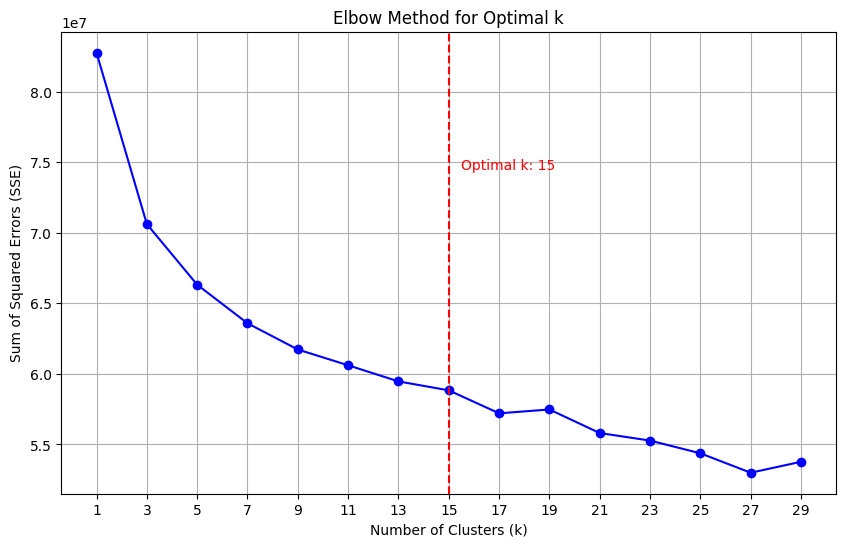


Recommended number of clusters: 15


In [71]:
# Run full analysis
optimal_k, sse_values, k_range = perform_full_analysis(few_missing_pca)

In [72]:
# Re-fit the k-means model with the selected number of clusters
model_general = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
model_general.fit(few_missing_pca)

# obtain cluster predictions for the general population demographics data.
predict_general = model_general.predict(few_missing_pca)

### Discussion 3.1: Apply Clustering to General Population

I performed K-means clustering on the PCA-transformed data, testing cluster counts from k=1 to k=29 (odd numbers only). Through rigorous elbow method analysis of the Sum of Squared Errors (SSE) reduction pattern, we identified k=15 as the optimal number of clusters, where the SSE reached 5.85e+07. This determination was made based on the following observations:

- A significant 29.3% SSE reduction occurred from k=1 to k=15

- Only an additional 8.2% improvement was achieved from k=15 to k=29

- The rate of SSE improvement dropped below 1% per additional cluster beyond k=15

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [73]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [74]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,0.0,1,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,0.0,2,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [75]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean = clean_data(customers)
customers_clean.head()

C:\Users\MOSAB PC\AppData\Local\Temp\ipykernel_21688\2174813164.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  few_missing = few_missing.replace(replacement_maps)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,4.0,1,5,1,5,1,2,2,1,1.0,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,0.0,1.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,5.0,1992.0,0,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,5.0,5.0,1.0,2.0,1.0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,3
1,4.0,0,5,1,5,1,4,4,1,2.0,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,0.0,2.0,1.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,1992.0,0,2.0,2.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,2.0,3.0,5.0,3.0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,3,4
2,4.0,1,5,1,5,2,1,2,0,2.0,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0.0,1.0,0.0,0.0,4.0,6.0,9.0,1.0,0.0,2.0,1992.0,0,3.0,0.0,0.0,0.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,3.0,4.0,1.0,3.0,1.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,4
3,3.0,1,3,1,4,4,5,2,0,3.0,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,0.0,2.0,4.0,0.0,6.0,2.0,9.0,7.0,0.0,1.0,1992.0,0,0.0,3.0,2.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,3.0,3.0,3.0,5.0,1.0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,3,0,4,1
4,3.0,1,5,1,5,1,2,3,1,3.0,3.0,6,4,4,1,7,6,4,6,2,5,5,3,3,4,0.0,2.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,2.0,1992.0,0,2.0,2.0,1.0,0.0,3.0,7.0,5.0,8.0,4.0,2.0,3.0,3.0,3.0,1167.0,2.0,3.0,2.0,1.0,5.0,5.0,3.0,7.0,5.0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,3,4


In [76]:
customers_clean.isnull().sum().sum()

0

In [77]:
# Ensure same columns exist in same order
missing_cols = set(test_df.columns) - set(customers_clean.columns)
extra_cols = set(customers_clean.columns) - set(test_df.columns)
print("missing columns is ", missing_cols)
print("extra columns is ", extra_cols)

missing columns is  {'GEBAEUDETYP_5.0'}
extra columns is  set()


In [78]:
# Add missing columns with 0 values
for col in missing_cols:
    customers_clean[col] = 0
    
# Remove extra columns
customers_clean = customers_clean[test_df.columns]



C:\Users\MOSAB PC\AppData\Local\Temp\ipykernel_21688\2692233816.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  customers_clean[col] = 0


In [79]:
# Apply feature scaling to the general population demographics data.
customers_scaled = scaler.transform(customers_clean) 
customers_scaled = pd.DataFrame(customers_scaled, columns = customers_clean.columns.tolist())
# PCA Transformation
customers_pca = pca.transform(customers_scaled) 

C:\Users\MOSAB PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [80]:
customer_clusters = model_general.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [81]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

def compare_clusters(general_clusters, customer_clusters):
    try:
        plt.figure(figsize=(14, 6))
        
        # Calculate percentages
        general_counts = pd.Series(general_clusters).value_counts(normalize=True).sort_index() * 100
        customer_counts = pd.Series(customer_clusters).value_counts(normalize=True).sort_index() * 100
        
        # Get all cluster labels present in either group
        all_clusters = sorted(set(general_counts.index) | set(customer_counts.index))
        
        # General Population
        plt.subplot(1, 2, 1)
        sns.barplot(x=general_counts.index, y=general_counts.values, color='skyblue', order=all_clusters)
        plt.title('General Population Cluster Distribution')
        plt.xlabel('Cluster')
        plt.ylabel('Percentage (%)')
        plt.ylim(0, max(max(general_counts), max(customer_counts)) + 5)  # Same scale for both
        
        # Customers
        plt.subplot(1, 2, 2)
        sns.barplot(x=customer_counts.index, y=customer_counts.values, color='salmon', order=all_clusters)
        plt.title('Customer Cluster Distribution')
        plt.xlabel('Cluster')
        plt.ylabel('Percentage (%)')
        plt.ylim(0, max(max(general_counts), max(customer_counts)) + 5)  # Same scale for both
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error generating plots: {str(e)}")
        # Fallback to simple value counts
        print("\nGeneral Population Cluster Counts:")
        print(pd.Series(general_clusters).value_counts().sort_index())
        print("\nCustomer Cluster Counts:")
        print(pd.Series(customer_clusters).value_counts().sort_index())

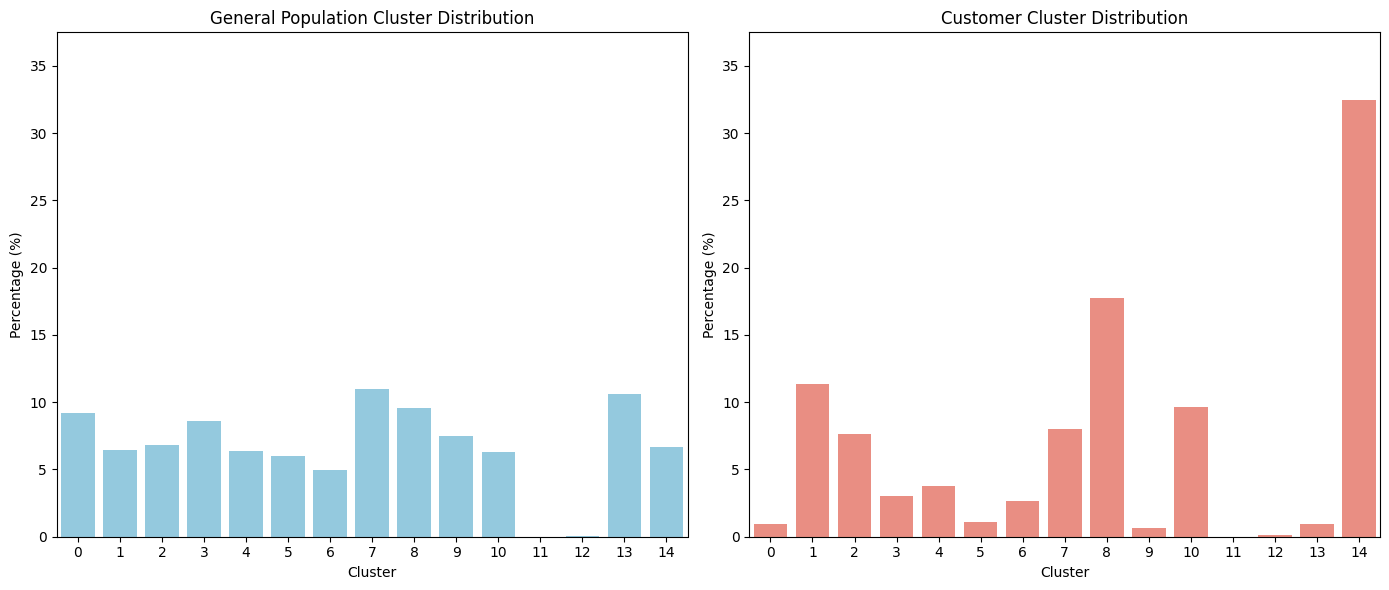

In [82]:
compare_clusters(predict_general, customer_clusters)

In [83]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

data = scaler.inverse_transform(pca.inverse_transform(customers_pca[np.where(customer_clusters == 8)])).round()
df = pd.DataFrame(data = data,
          index = np.array(range(0, data.shape[0])),
          columns = few_missing.columns)
df.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,3.0,1.0,6.0,1.0,5.0,2.0,1.0,2.0,-0.0,2.0,3.0,4.0,5.0,4.0,3.0,6.0,5.0,4.0,5.0,3.0,2.0,2.0,2.0,3.0,3.0,0.0,1.0,2.0,0.0,3.0,6.0,9.0,1.0,-0.0,4.0,1991.0,-0.0,2.0,1.0,0.0,0.0,4.0,6.0,1.0,7.0,4.0,3.0,4.0,2.0,5.0,771.0,3.0,2.0,1.0,0.0,3.0,4.0,1.0,2.0,1.0,0.0,1.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,1.0,0.0,0.0,0.0,-0.0,1.0,-0.0,-0.0,-0.0,1.0,0.0,1.0,0.0,-0.0,1.0,-0.0,-0.0,0.0,1.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,1.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,1.0,-0.0,0.0,-0.0,-0.0,-0.0,2.0,-0.0,2.0,3.0
1,4.0,1.0,5.0,2.0,4.0,3.0,2.0,1.0,-0.0,2.0,3.0,4.0,5.0,4.0,3.0,6.0,5.0,4.0,5.0,2.0,2.0,2.0,2.0,3.0,2.0,-0.0,1.0,3.0,0.0,3.0,2.0,9.0,1.0,0.0,4.0,1995.0,0.0,3.0,0.0,0.0,-0.0,4.0,6.0,1.0,7.0,4.0,3.0,4.0,4.0,5.0,1117.0,4.0,1.0,0.0,-0.0,4.0,5.0,1.0,2.0,1.0,0.0,0.0,0.0,-0.0,1.0,-0.0,0.0,0.0,0.0,0.0,-0.0,1.0,0.0,0.0,-0.0,1.0,-0.0,-0.0,0.0,-0.0,1.0,0.0,1.0,0.0,-0.0,1.0,-0.0,-0.0,0.0,1.0,-0.0,0.0,-0.0,-0.0,0.0,1.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,-0.0,2.0,2.0
2,1.0,0.0,5.0,0.0,5.0,1.0,1.0,3.0,-0.0,3.0,3.0,5.0,4.0,5.0,3.0,3.0,2.0,4.0,4.0,6.0,6.0,7.0,5.0,6.0,6.0,-0.0,2.0,2.0,-0.0,3.0,5.0,9.0,4.0,0.0,3.0,1994.0,-0.0,3.0,1.0,-0.0,-0.0,5.0,6.0,2.0,7.0,3.0,1.0,5.0,2.0,1.0,1014.0,3.0,2.0,0.0,-0.0,4.0,5.0,1.0,2.0,1.0,0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,0.0,0.0,-0.0,1.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,1.0,0.0,1.0,-0.0,0.0,0.0,-0.0,-0.0,1.0,0.0,0.0,1.0,-0.0,0.0,-0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.0,-0.0,-0.0,1.0,-0.0,1.0,3.0
3,2.0,1.0,6.0,1.0,5.0,2.0,2.0,1.0,-0.0,2.0,3.0,5.0,6.0,6.0,7.0,7.0,4.0,3.0,6.0,5.0,3.0,3.0,2.0,5.0,5.0,-0.0,1.0,3.0,-0.0,2.0,2.0,9.0,0.0,0.0,5.0,1996.0,-0.0,3.0,-0.0,-0.0,-0.0,5.0,6.0,1.0,7.0,4.0,3.0,5.0,5.0,6.0,1055.0,4.0,1.0,-0.0,-0.0,4.0,5.0,1.0,1.0,1.0,-0.0,0.0,1.0,0.0,0.0,-0.0,-0.0,1.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,1.0,0.0,-0.0,-0.0,0.0,1.0,0.0,1.0,0.0,-0.0,-0.0,1.0,-0.0,0.0,1.0,0.0,-0.0,-0.0,0.0,-0.0,1.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,1.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,3.0,-0.0,1.0,2.0
4,4.0,1.0,5.0,0.0,5.0,1.0,1.0,3.0,-0.0,2.0,3.0,4.0,5.0,3.0,5.0,7.0,7.0,5.0,5.0,2.0,4.0,3.0,3.0,3.0,2.0,-0.0,1.0,2.0,-0.0,4.0,6.0,9.0,4.0,-0.0,3.0,1991.0,0.0,2.0,1.0,0.0,0.0,4.0,5.0,2.0,6.0,4.0,4.0,4.0,2.0,7.0,1344.0,3.0,3.0,1.0,0.0,5.0,5.0,2.0,3.0,1.0,0.0,0.0,1.0,-0.0,-0.0,-0.0,-0.0,1.0,0.0,-0.0,-0.0,0.0,0.0,1.0,-0.0,-0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.0,0.0,-0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.

In [84]:
data_2 = scaler.inverse_transform(pca.inverse_transform(few_missing_pca[np.where(predict_general == 8)])).round()
df_2 = pd.DataFrame(data = data_2,
          index = np.array(range(0, data_2.shape[0])),
          columns = few_missing.columns)
df_2.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,3.0,1.0,4.0,3.0,3.0,3.0,3.0,2.0,-0.0,3.0,4.0,6.0,5.0,4.0,4.0,6.0,5.0,5.0,5.0,3.0,5.0,3.0,3.0,3.0,3.0,-0.0,2.0,1.0,-0.0,5.0,5.0,8.0,6.0,-0.0,4.0,1992.0,0.0,2.0,3.0,0.0,0.0,3.0,5.0,3.0,5.0,5.0,4.0,3.0,0.0,6.0,1219.0,3.0,2.0,1.0,0.0,5.0,5.0,2.0,4.0,1.0,0.0,1.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,1.0,-0.0,0.0,0.0,1.0,-0.0,0.0,0.0,0.0,1.0,-0.0,0.0,0.0,0.0,1.0,0.0,-0.0,-0.0,1.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,1.0,1.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,4.0,-0.0,2.0,4.0
1,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,-0.0,2.0,5.0,4.0,4.0,3.0,3.0,6.0,7.0,6.0,4.0,2.0,3.0,3.0,3.0,2.0,3.0,0.0,2.0,3.0,0.0,3.0,3.0,9.0,2.0,-0.0,4.0,1992.0,0.0,3.0,1.0,0.0,0.0,4.0,5.0,3.0,6.0,4.0,3.0,4.0,3.0,5.0,568.0,3.0,2.0,0.0,0.0,3.0,4.0,3.0,3.0,3.0,0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,1.0,0.0,-0.0,0.0,0.0,1.0,0.0,0.0,-0.0,1.0,0.0,1.0,-0.0,0.0,0.0,0.0,1.0,-0.0,1.0,0.0,-0.0,0.0,-0.0,0.0,1.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,1.0,-0.0,0.0,-0.0,-0.0,-0.0,2.0,-0.0,2.0,4.0
2,3.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,-0.0,3.0,5.0,4.0,4.0,4.0,1.0,5.0,4.0,4.0,5.0,3.0,3.0,4.0,3.0,3.0,3.0,0.0,2.0,3.0,0.0,3.0,3.0,9.0,-1.0,-0.0,3.0,1991.0,-0.0,4.0,-0.0,0.0,0.0,5.0,6.0,4.0,6.0,4.0,3.0,5.0,4.0,5.0,427.0,3.0,2.0,1.0,0.0,3.0,4.0,4.0,5.0,5.0,0.0,0.0,1.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.0,0.0,0.0,1.0,0.0,-0.0,-0.0,1.0,0.0,1.0,0.0,-0.0,1.0,-0.0,0.0,0.0,1.0,-0.0,0.0,0.0,-0.0,0.0,1.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,1.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,2.0,-0.0,2.0,5.0
3,3.0,1.0,4.0,1.0,5.0,2.0,2.0,4.0,0.0,3.0,4.0,6.0,5.0,4.0,3.0,6.0,5.0,4.0,5.0,3.0,2.0,3.0,3.0,4.0,3.0,-0.0,2.0,4.0,0.0,3.0,4.0,9.0,4.0,-0.0,3.0,1994.0,0.0,2.0,2.0,0.0,0.0,3.0,6.0,3.0,6.0,4.0,3.0,3.0,5.0,6.0,1088.0,3.0,3.0,1.0,0.0,5.0,5.0,3.0,3.0,3.0,0.0,-0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,1.0,-0.0,1.0,-0.0,0.0,-0.0,1.0,0.0,-0.0,-0.0,0.0,0.0,1.0,1.0,0.0,-0.0,-0.0,-0.0,0.0,1.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,1.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,2.0,0.0,2.0,5.0
4,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,-0.0,2.0,5.0,6.0,5.0,3.0,4.0,6.0,8.0,5.0,5.0,2.0,4.0,3.0,3.0,3.0,2.0,-0.0,2.0,1.0,0.0,4.0,6.0,8.0,3.0,-0.0,5.0,1993.0,-0.0,3.0,1.0,0.0,0.0,4.0,6.0,2.0,6.0,5.0,4.0,4.0,1.0,7.0,250.0,4.0,2.0,-0.0,-0.0,2.0,3.0,2.0,2.0,2.0,-0.0,1.0,0.0,0.0,0.0,0.0,-0.0,1.0,0.0,0.0,-0.0,0.0,1.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.0,0.0,-0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.0,1.0,0.

In [85]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

data_3 = scaler.inverse_transform(pca.inverse_transform(customers_pca[np.where(customer_clusters == 13)])).round()
df = pd.DataFrame(data = data_3,
          index = np.array(range(0, data_3.shape[0])),
          columns = few_missing.columns)
df.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,2.0,0.0,2.0,2.0,4.0,2.0,1.0,5.0,-0.0,2.0,3.0,4.0,5.0,7.0,7.0,2.0,3.0,4.0,5.0,7.0,5.0,6.0,6.0,7.0,6.0,-0.0,1.0,2.0,0.0,5.0,6.0,9.0,34.0,-0.0,0.0,1991.0,1.0,-0.0,0.0,0.0,2.0,1.0,1.0,6.0,2.0,1.0,3.0,1.0,1.0,6.0,701.0,1.0,2.0,3.0,2.0,5.0,3.0,4.0,9.0,3.0,0.0,1.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,1.0,0.0,1.0,-0.0,-0.0,0.0,1.0,-0.0,0.0,0.0,0.0,1.0,0.0,-0.0,-0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.0,1.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,1.0,2.0,-0.0,5.0,1.0
1,3.0,-0.0,1.0,5.0,2.0,4.0,4.0,4.0,0.0,2.0,1.0,3.0,3.0,3.0,4.0,3.0,6.0,6.0,3.0,4.0,5.0,6.0,6.0,4.0,3.0,0.0,1.0,4.0,-0.0,6.0,2.0,8.0,3.0,0.0,2.0,1992.0,0.0,-0.0,3.0,2.0,-0.0,2.0,4.0,5.0,5.0,3.0,3.0,2.0,5.0,5.0,566.0,2.0,4.0,2.0,1.0,4.0,3.0,4.0,7.0,5.0,-0.0,-0.0,0.0,0.0,0.0,1.0,1.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,1.0,1.0,-0.0,0.0,0.0,-0.0,1.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,-0.0,-0.0,0.0,1.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,1.0,-0.0,-0.0,-0.0,-0.0,0.0,1.0,0.0,0.0,0.0,5.0,0.0,4.0,4.0
2,2.0,-0.0,1.0,4.0,3.0,5.0,3.0,5.0,0.0,2.0,5.0,4.0,4.0,6.0,6.0,2.0,7.0,5.0,4.0,6.0,5.0,6.0,6.0,6.0,5.0,0.0,1.0,2.0,-0.0,5.0,5.0,9.0,3.0,0.0,3.0,1993.0,1.0,0.0,0.0,3.0,-0.0,2.0,2.0,6.0,2.0,4.0,4.0,2.0,2.0,6.0,561.0,1.0,3.0,3.0,2.0,4.0,2.0,4.0,8.0,3.0,0.0,0.0,-0.0,-0.0,-0.0,1.0,1.0,0.0,-0.0,-0.0,0.0,0.0,1.0,0.0,-0.0,-0.0,1.0,1.0,0.0,0.0,-0.0,0.0,1.0,-0.0,0.0,0.0,-0.0,0.0,1.0,-0.0,-0.0,0.0,0.0,-0.0,1.0,1.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,1.0,-0.0,4.0,0.0,4.0,3.0
3,1.0,0.0,3.0,2.0,4.0,2.0,1.0,5.0,0.0,3.0,2.0,6.0,5.0,6.0,4.0,3.0,2.0,3.0,5.0,6.0,5.0,6.0,6.0,7.0,7.0,0.0,2.0,4.0,0.0,6.0,3.0,9.0,22.0,-0.0,2.0,1992.0,1.0,-0.0,0.0,0.0,2.0,1.0,4.0,5.0,4.0,3.0,4.0,1.0,3.0,6.0,287.0,1.0,3.0,3.0,2.0,3.0,1.0,4.0,7.0,3.0,-0.0,1.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,1.0,-0.0,-0.0,0.0,0.0,1.0,1.0,-0.0,-0.0,0.0,0.0,1.0,-0.0,-0.0,-0.0,-0.0,0.0,1.0,-0.0,-0.0,0.0,1.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,1.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,1.0,2.0,0.0,5.0,1.0
4,2.0,-0.0,2.0,4.0,1.0,4.0,3.0,4.0,0.0,3.0,3.0,2.0,3.0,4.0,4.0,2.0,2.0,4.0,3.0,6.0,6.0,8.0,7.0,5.0,6.0,-0.0,2.0,1.0,-0.0,5.0,4.0,3.0,10.0,0.0,4.0,1994.0,1.0,1.0,3.0,1.0,0.0,3.0,2.0,5.0,2.0,5.0,2.0,3.0,4.0,3.0,864.0,2.0,3.0,2.0,1.0,4.0,4.0,4.0,7.0,2.0,-0.0,-0.0,1.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.0,0.0,0.0,0.0,1.0,-0.0,0.0,0.0,-0.0,1.0,0.0,0.0,0.0,-0.0,0.0,1.0,-0.0,0.0,0.0,-

In [86]:
data_4 = scaler.inverse_transform(pca.inverse_transform(few_missing_pca[np.where(predict_general==13)])).round()
df = pd.DataFrame(data=data_4,
          index=np.array(range(0, data_4.shape[0])),
          columns=few_missing.columns)
df.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,1.0,0.0,1.0,5.0,2.0,5.0,4.0,4.0,-0.0,3.0,0.0,5.0,4.0,5.0,4.0,2.0,2.0,3.0,4.0,6.0,5.0,6.0,5.0,6.0,6.0,1.0,2.0,1.0,0.0,6.0,2.0,9.0,21.0,-0.0,1.0,1992.0,-0.0,0.0,0.0,0.0,2.0,1.0,7.0,3.0,7.0,3.0,2.0,1.0,4.0,3.0,1009.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,4.0,4.0,0.0,0.0,-0.0,-0.0,1.0,-0.0,1.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,1.0,-0.0,0.0,1.0,0.0,-0.0,-0.0,0.0,1.0,0.0,0.0,0.0,-0.0,-0.0,1.0,0.0,0.0,0.0,-0.0,1.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,1.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,1.0,0.0,5.0,-0.0,5.0,2.0
1,2.0,-0.0,1.0,4.0,2.0,4.0,4.0,5.0,0.0,1.0,1.0,4.0,4.0,6.0,6.0,2.0,2.0,5.0,4.0,7.0,5.0,6.0,7.0,6.0,6.0,0.0,1.0,1.0,0.0,6.0,5.0,9.0,7.0,0.0,1.0,1991.0,0.0,-0.0,2.0,3.0,-0.0,2.0,1.0,7.0,2.0,3.0,3.0,1.0,3.0,6.0,362.0,1.0,4.0,3.0,1.0,4.0,2.0,4.0,9.0,5.0,0.0,0.0,0.0,-0.0,-0.0,1.0,1.0,0.0,0.0,0.0,0.0,-0.0,1.0,-0.0,-0.0,-0.0,0.0,1.0,-0.0,-0.0,0.0,-0.0,1.0,0.0,-0.0,-0.0,1.0,0.0,0.0,0.0,0.0,-0.0,1.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,1.0,4.0,0.0,5.0,1.0
2,2.0,-0.0,2.0,2.0,4.0,1.0,2.0,4.0,0.0,2.0,3.0,3.0,4.0,5.0,6.0,2.0,3.0,4.0,3.0,6.0,6.0,7.0,6.0,6.0,5.0,-0.0,2.0,3.0,0.0,5.0,3.0,9.0,6.0,-0.0,1.0,1993.0,0.0,1.0,3.0,0.0,0.0,3.0,1.0,6.0,2.0,3.0,1.0,2.0,3.0,1.0,659.0,2.0,4.0,2.0,1.0,4.0,3.0,4.0,8.0,4.0,0.0,0.0,0.0,1.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,1.0,-0.0,0.0,0.0,-0.0,-0.0,1.0,1.0,-0.0,-0.0,0.0,0.0,-0.0,1.0,-0.0,-0.0,1.0,0.0,-0.0,0.0,0.0,1.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,1.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,1.0,0.0,2.0,0.0,4.0,1.0
3,2.0,-0.0,1.0,4.0,2.0,3.0,4.0,4.0,0.0,3.0,2.0,3.0,3.0,5.0,3.0,2.0,2.0,4.0,3.0,6.0,6.0,7.0,7.0,5.0,6.0,-0.0,2.0,1.0,0.0,5.0,5.0,4.0,12.0,-0.0,1.0,1992.0,0.0,0.0,-0.0,2.0,1.0,2.0,0.0,7.0,2.0,3.0,1.0,1.0,4.0,2.0,698.0,1.0,4.0,3.0,2.0,4.0,3.0,3.0,9.0,4.0,1.0,-0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,1.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,0.0,-0.0,1.0,-0.0,0.0,0.0,-0.0,1.0,-0.0,0.0,0.0,-0.0,1.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,1.0,0.0,5.0,0.0,5.0,2.0
4,1.0,0.0,1.0,5.0,2.0,4.0,4.0,4.0,0.0,3.0,1.0,4.0,5.0,6.0,4.0,2.0,2.0,2.0,5.0,6.0,5.0,6.0,5.0,7.0,6.0,0.0,2.0,3.0,0.0,5.0,5.0,9.0,19.0,-0.0,2.0,1993.0,0.0,0.0,0.0,-0.0,2.0,1.0,2.0,6.0,3.0,3.0,3.0,1.0,3.0,7.0,547.0,1.0,3.0,3.0,2.0,4.0,3.0,4.0,8.0,4.0,0.0,0.0,0.0,1.0,-0.0,-0.0,1.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,1.0,1.0,0.0,-0.0,0.0,-0.0,0.0,1.0,0.0,1.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,1.0,0.0,-0.0,0.0,0.0,

### Discussion 3.3: Compare Customer Data to Demographics Data

The clustering analysis provides valuable insights into population segments based on their alignment with the mail-order company’s customer base. By comparing clusters 8 and 13 from both the **general population** and the **customer dataset**, clear differences in demographic patterns and lifestyle indicators emerge.

**Cluster 8** appears to represent a segment that is **popular with the mail-order company**, as its presence is strong within both customer and general datasets, with consistent characteristics:
- Predominantly **middle-aged to older individuals** (ALTERSKATEGORIE_GROB around 3–4),
- High scores in **conservative lifestyle indicators** like SEMIO_TRADV and SEMIO_PFLICHT,
- Above-average representation in household-related features such as ANZ_HAUSHALTE_AKTIV and WOHNDAUER_2008.

In contrast, **Cluster 13** is relatively **underrepresented** in the customer dataset compared to its footprint in the general population. This segment seems to include:
- A wider age distribution, sometimes skewed younger,
- More **diverse shopper types** and greater representation from specific FINANZ segments that don’t align with the core customer profile,
- A somewhat higher prevalence of **urban or rental-oriented housing types** (e.g., GEBAEUDETYP_3.0 or ONLINE_AFFINITAET high),
- Fewer strong lifestyle indicators, implying lower affinity with typical mail-order behavior.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.